编辑人:苏则茜
Project:Prob-Na-Learning
+ WBI行为数据分析：时间轴对齐，运动参数提取
+ 数据裁剪，数据拼接

# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import os
import csv
import cv2
import heapq
from scipy.ndimage import label
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.ndimage import grey_opening,grey_closing
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
import networkx as nx
from scipy.interpolate import interp1d
from scipy import ndimage
from scipy.interpolate import splprep, splev
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from datetime import datetime
# 设置字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# Preprocessing function definition

## Coordination Alignment 

In [ ]:
def Realign_coordinate(p_f, df_motion): 
    '''
    不同琼脂垫空间对齐
    2025.2.27：目前stage calibrate设置原点在右下角，这个代码将原点根据四个标定点重新设为左上角。
    另外根据x轴轨迹做镜面翻转
    '''
    
    # 初始化
    df_ul = pd.DataFrame({})
    df_ur = pd.DataFrame({})
    df_ll = pd.DataFrame({})
    df_lr = pd.DataFrame({})
    files = [f for f in os.listdir(p_f) if '.txt' in f ]
    
    # 找到四个顶点的坐标
    for f in files:
        if 'upper_left' in f:
            # 运动参数位置文件
            column_names = [ 'X', 'Y']
            df_ul = pd.read_csv(os.path.join(p_f, f),sep=r',', header=None, names=column_names)
            if len(df_ul) == 1:
                df_ul.index = ['upper_left']
            else:
                raise ValueError('upper_left 标记数量不对')
        if 'upper_right' in f:
            # 运动参数位置文件
            column_names = [ 'X', 'Y']
            df_ur = pd.read_csv(os.path.join(p_f, f),sep=r',', header=None, names=column_names)
            if len(df_ur) == 1:
                df_ur.index = ['upper_right']
            else:
                raise ValueError('upper_right 标记数量不对')
        if ('lower_left' in f) :
            # 运动参数位置文件
            column_names = [ 'X', 'Y']
            df_ll = pd.read_csv(os.path.join(p_f, f),sep=r',', header=None, names=column_names)
            if len(df_ll) == 1:
                df_ll.index = ['lower_left']
            else:
                raise ValueError('lower_left 标记数量不对')
        if 'lower_right' in f:
            # 运动参数位置文件
            column_names = [ 'X', 'Y']
            df_lr = pd.read_csv(os.path.join(p_f, f),sep=r',', header=None, names=column_names)
            if len(df_lr) == 1:
                df_lr.index = ['lower_right']
            else:
                raise ValueError('lower_right 标记数量不对')

    df_label = pd.concat([df_ul, df_ll, df_ur, df_lr])
    df_label['X'] = df_label['X'].astype(float)/1000
    df_label['Y'] = df_label['Y'].astype(float)/1000
    # 调整x坐标(平移y轴)
    x_min = (df_label.loc['upper_left','X'] + df_label.loc['lower_left','X'])/2
    x_max = (df_label.loc['upper_right','X'] + df_label.loc['lower_right','X'])/2
    if x_min > x_max:
        # 如果原点在高钠一侧，则需要减去left的坐标后将X坐标值变号
        # 目前的情况
        df_motion_r = df_motion.copy()
        df_motion_r['X'] = df_motion_r['X']-x_min
        df_motion_r['X'] = -df_motion_r['X']
    else:
        df_motion_r = df_motion.copy()
        df_motion_r['X'] = df_motion_r['X']-x_min
        
    # 调整y轴坐标，平移x轴  (另外y轴会和原坐标翻转)
    y_min = (df_label.loc['lower_left','Y'] + df_label.loc['lower_right','Y'])/2
    y_max = (df_label.loc['upper_left','Y'] + df_label.loc['upper_right','Y'])/2
    
    if y_min > y_max:
        df_motion_r1 = df_motion_r.copy()
        df_motion_r1['Y'] = df_motion_r1['Y']-y_max
    else:
        # 目前的情况
        df_motion_r1 = df_motion_r.copy()
        df_motion_r1['Y'] = df_motion_r1['Y']-y_max
        df_motion_r1['Y'] = -df_motion_r1['Y']
    return df_label, df_motion_r1

In [ ]:
def Realign_coordinate_by_edge(p_f, df_motion):
    '''
    旧数据标记edge0和edge45,需要判断0和4.5哪一个在左侧,然后将x轴原点设置在0g边缘,且正方向与梯度相同
    只修改x轴,不改y轴数据
    '''
    # 初始化
    df_ul = pd.DataFrame({})
    df_ur = pd.DataFrame({})
    df_ll = pd.DataFrame({})
    df_lr = pd.DataFrame({})
    edge0_x, edge45_x = None, None  # 初始化

    files = [f for f in os.listdir(p_f) if ('.txt' in f) and ('edge' in f)]
    # 找到两个边界文件
    for f in files:
        if 'edge0' in f:
            edge0 = np.loadtxt(os.path.join(p_f, f), delimiter=',')
            edge0_x = edge0[:, 0]
        elif 'edge45' in f:
            edge45 = np.loadtxt(os.path.join(p_f, f), delimiter=',')
            edge45_x = edge45[:, 0]

    # 检查是否都找到
    if edge0_x is None or edge45_x is None:
        raise FileNotFoundError("需要同时包含 edge0 和 edge45 文件，但在 {} 中未找到完整文件".format(p_f))
    
    rand_seq_0 = np.random.randint(0, 2, size=len(edge0_x))
    mean_x0 = np.mean(edge0_x[rand_seq_0==1])/1000
    rand_seq_45 = np.random.randint(0, 2, size=len(edge45_x))
    mean_x45 = np.mean(edge45_x[rand_seq_45==1])/1000
    print(f'edge0的x平均坐标为{mean_x0},edge45的x平均坐标为{mean_x45}')
    if mean_x0 > mean_x45:
        print("0的坐标更大，说明需要在减去0边界的x坐标后完成坐标轴转换")
        df_motion_r = df_motion.copy()
        df_motion_r['X'] = df_motion_r['X']-mean_x0
        df_motion_r['X'] = -df_motion_r['X']
    else:
        print("不需要坐标轴转换，只需要将原点平移到edge0")
        df_motion_r = df_motion.copy()
        df_motion_r['X'] = df_motion_r['X']-mean_x0
    
    # 作图验证
    plt.scatter(df_motion_r['X'], df_motion_r['Y'], s=0.7, c=df_motion_r['Time'], cmap='Reds')
    plt.title(os.path.basename(p_f))
    plt.show()
    
    return df_motion_r
    

## Visualization Functions

In [ ]:
def cut_and_draw(df, n, alg_spd = 1, CTX = 0, speed = 0,turn=1, reorientation=1):
    # 将轨迹分段可视化
    df_idx_list = np.arange(0, len(df), n)   # 切数据
    for i, idx in enumerate(df_idx_list[:-1]):
        df_d = df.loc[idx: df_idx_list[i+1], :]
        plt.figure()
        plt.scatter(df_d.X,df_d.Y, s=0.8,c = df_d.Time, cmap='jet')
        ax = plt.gca()
        plt.title(f'idx{idx}')
        plt.colorbar(label='Time(s)')
        ax.set_aspect(1)
        plt.show()
        
        if alg_spd:
            #画角速度
            fig, ax = plt.subplots(1,2)
            ax1 = ax[0].scatter(df_d.X,df_d.Y, s=0.8,c = df_d.agl_speed, cmap='jet')
            plt.title(f'idx{idx} agl_speed')
            plt.colorbar(ax1, label='Time(s)')
            ax[0].set_aspect(1)
            ax[1].hist(df_d.agl_speed)
            plt.show()
        if CTX:
            # 画CTX
            fig, ax = plt.subplots(1,2)
            ax1 = ax[0].scatter(df_d.X,df_d.Y, s=0.8,c = df_d.CTX_left, cmap='jet')
            plt.title(f'idx{idx} CTX')
            plt.colorbar(ax1, label='Time(s)')
            ax[0].set_aspect(1)
            ax[1].hist(df_d.CTX_left)
            ax[1].set_title('CTX_left distribution')
            plt.show()
        if speed:
            # 画速度
            fig, ax = plt.subplots(1,2)
            ax1 = ax[0].scatter(df_d.X,df_d.Y, s=0.8,c = df_d.speed, cmap='jet')
            plt.title(f'idx{idx} agl_speed')
            plt.colorbar(ax1,label='Time(s)')
            ax[0].set_aspect(1)
            ax[1].hist(df_d.speed)
            ax[1].set_title('speed distribution')
            plt.show()
        if reorientation:
            fig, ax = plt.subplots(1,2)
            ax[1].scatter(df_d.X, df_d.Y, c = 'grey',s=0.8, alpha=0.05)
            ax[0].scatter(df_d.X, df_d.Y, c = 'grey',s=0.8, alpha=0.05)
            df_pt = df_d[df_d.Reorientation==1]
            df_tn = df_d[df_d.Event==1]
            ax[0].scatter(df_tn.X, df_tn.Y, s = 0.8, c='r')
            ax[1].scatter(df_pt.X, df_pt.Y, s = 0.8, c='r')
            ax[0].set_title('Sharp turn')
            ax[1].set_title('Reorientation')
            plt.show()

In [ ]:
def Scatter_Pos_Grad_Dir(df, Pos_CTX_vec, scale_size = 2, folder = '', x_lim=[]):
    fig,ax = plt.subplots(1,1)
    
    mean_x = df.X.mean()
    mean_y = df.Y.mean()
    origin = [mean_x, mean_y]
    vector = np.array(Pos_CTX_vec)*scale_size
    
    plt.quiver(*origin, *vector, angles='xy', scale_units='xy',
               scale=1, color='k', label='Pos_CTX_vec')
    plt.legend()
    plt.scatter(df.X,df.Y, s=0.8,c = df.Time, cmap='jet')
    ax = plt.gca()
    plt.colorbar(label='Time(s)')
    
    if len(x_lim):
        plt.xlim(*x_lim)
    ax.set_aspect(1)
    if folder:
        fig.savefig(folder+'Pos-Grad-Dir.png')
    else:
        plt.show()

In [ ]:
def Scatter_Pirouette(df, folder = '', x_lim = []):
    fig,ax = plt.subplots(1,1)
    plt.scatter(df.X, df.Y, c = 'grey',s=0.8, alpha=0.05)
    df_pt = df[df.Reorientation==1]
    plt.scatter(df_pt.X, df_pt.Y, s = 0.8, c='r')
    plt.title('Reorientation')
    if len(x_lim):
        plt.xlim(*x_lim)
    ax.set_aspect(1)
    if folder:
        fig.savefig(folder+'Visual_Reorientation.png')
    else:
        plt.show()

In [ ]:
def map_color_dict(key_items,color_map='tab10'):
    '''
    # 提前生成统一的color_dict()
    # color(根据dates元素的数量分配，输出以key_items元素(可以是condition或dates)为key的颜色映射字典)
    '''
    
    color_vec_norm = np.linspace(0.01,0.99,len(key_items)+1)
    colormap = mpl.colormaps[color_map]
    colors  = colormap(color_vec_norm)
    color_dict = {}
    for i, d in enumerate(key_items):
        color_dict[d] = colors[i]
    return color_dict

In [ ]:
def set_time_intervals(df, time_len, time_inv, time_col='Vol_Time'):
    """
    设置时间间隔并为 DataFrame 添加时间段标签。
    时间列单位为s，不需要frame_rate

    Parameters:
    - df: 输入 DataFrame，需包含 'Timestamp' 列。
    - time_len: 总时间长度（小时）。
    - time_inv: 时间间隔（分钟）。

    Returns:
    - 更新后的 DataFrame，添加了 'Period_label' 列。
    - 时间段标签列表。
    """
    periods = np.arange(0, time_len + 1, time_inv)
    labels = [(periods[i] + periods[i + 1]) / 2 for i in range(len(periods) - 1)]
    df['Period_label'] = pd.cut(
        df[time_col], bins=periods, labels=labels, right=False, include_lowest=True
    )
    return df, labels

## Motion Parameter Extract Functions

### 角度计算  
  Pirouette labeling(outdated)

In [ ]:
# 定义角度计算公式
def ang_cal(vec_1,vec_2):
    dot_pro = np.dot(vec_1, vec_2)
    mod_1 = np.sqrt(np.dot(vec_1,vec_1))
    mod_2 = np.sqrt(np.dot(vec_2,vec_2)) 
    if mod_1 == 0 or mod_2 ==0:
        angle = 0
    else:
        cos = dot_pro/(mod_1*mod_2)
        if np.isnan(cos) == True:
            angle = np.nan
        else:  
            angle = np.arccos(round(cos,1))  #弧度制
    return angle

def clws_delta_phi(vec_1, vec_2, vec_0 = [1,0]):
    # vec_1 is the first vector, and it rotates to the vec_2
    vec_0 = np.array(vec_0)
    agl_1 = ang_cal(vec_1,vec_2)
    agl_2 = ang_cal(vec_0, vec_1)
    agl_3 = ang_cal(vec_0, vec_2)
    if agl_1 == 0:
        agl_1 = 0
        # print('angle = 0°')
    elif agl_1 == np.pi:
        agl_1 = np.pi
        # print('angle = 180°')
    elif vec_1[1] >= 0 and vec_2[1] >= 0:    #同时在第一第二象限
        if (agl_3 - agl_2) > 0:
            agl_1 = (-1)*np.abs(agl_1)
        else:
            agl_1 = np.abs(agl_1)
    elif vec_1[1] <= 0 and vec_2[1] <= 0:    #同时在第三第四象限
        if (agl_3 - agl_2) > 0:
            agl_1 = np.abs(agl_1)
        else:
            agl_1 = (-1)*np.abs(agl_1)
    elif vec_1[1] >= 0 and vec_2[1] <= 0:
        if (agl_3 + agl_2) > np.pi:
            agl_1 = (-1)*np.abs(agl_1)
        else:                                  #如果等于180°认为是顺时针旋转
            agl_1 = np.abs(agl_1)
    elif vec_1[1] <= 0 and vec_2[1] >= 0:
        if (agl_3 + agl_2) < np.pi:
            agl_1 = (-1)*np.abs(agl_1)
        else:                                  #如果等于180°认为是顺时针旋转
            agl_1 = np.abs(agl_1)   
    return agl_1*180/np.pi

In [ ]:
# def Label_Pirouettes_by_id(g_df,t_crit=6.16, frame_rate = 30,min_agl_spd=None):
#     '''根据角速度和turn的间隔标记Pirouette'''
#     # 输入：同一个id的df, t_crit(sec)，如果需要重新分turn可以输入min_agl_spd
#     # 注意输入的df中不能是不同组混合的，id必须独立
#     t_f_crit = t_crit*frame_rate
#     if min_agl_spd:
#         g_df.loc[:,'Event']=0
#         g_df.loc[g_df.agl_speed >= min_agl_spd, 'Event']=1
        
#     g_df.loc[:,'Reorientation']=g_df['Event']
#     g_df = g_df.reset_index(drop=True)
#     # nan值是计算速度和角速度时舍弃的点，默认是0不计算c
#     event_vec = g_df.Event.fillna(0).values

#     # 向后移动一位，上下相减
#     diff_vec = event_vec[1:]-event_vec[:-1]
#     if (diff_vec==0).all():
#         pass
#     elif ~(diff_vec==-1).any() or ~(diff_vec==1).any():
#         print('只有结尾有turn或只有开头有turn')
#     else:
#         # 统计所有出现1和-1的索引
#         idx_1 = np.where(diff_vec == 1)[0]
#         idx_n1 = np.where(diff_vec == -1)[0]
#         if np.min(idx_1)<np.min(idx_n1):
#             # 如果最小的索引是1而不是-1，说明开头是run，然后才开始出现turn
#             if len(idx_1)>len(idx_n1):
#                 # 如果1的数量大于-1,说明最后一个turn没有结束
# #                 print(f'验证最后是否以turn结束:{(np.max(idx_n1)<np.max(idx_1))}')
#                 # 去掉第一个1的索引，用1减去所有-1的索引，判断长度
#                 run_lens_btw_turns = idx_1[1:]-idx_n1
#                 for i,r in enumerate(run_lens_btw_turns):
#                     if r <= t_f_crit:
#                         low_b = idx_n1[i]+1
#                         upper_b = idx_1[i+1]+1      # 注意idx_1去头，所以索引内加以
#                         g_df.loc[low_b:upper_b, 'Reorientation']=1

#             elif len(idx_1)==len(idx_n1):
#                 # 如果两者数量相同，说明最后以run结尾，这条轨迹前后是完整的多个turn
# #                 print(f'验证最后是否以run结束:{(np.max(idx_n1)>np.max(idx_1))}')
#                 # 去掉1的所索引的首部和-1的尾部，用1减去-1的索引判断长度
#                 run_lens_btw_turns = idx_1[1:]-idx_n1[:-1]
#                 for i,r in enumerate(run_lens_btw_turns):
#                     if r <= t_f_crit:
#                         low_b = idx_n1[i]+1
#                         upper_b = idx_1[i+1]+1
#                         g_df.loc[low_b:upper_b, 'Reorientation']=1

#             # 无论是上述哪种情况，turn的数量都记为出现1的数量
#             num_turn = len(idx_1)
# #             print(f'Turn number: {num_turn}')
#         elif np.min(idx_1)>np.min(idx_n1):
#             # 如果最小索引是-1而不是1，说明开头就是turn
#             if (len(idx_n1)== len(idx_1)+1):
#                 # 如果-1比1多一个，说明以run结尾
# #                 print(f'验证最后是否以run结束:{(np.max(idx_n1)>np.max(idx_1))}')
#                 # 去掉最后一个-1的索引，用1减去-1
#                 run_lens_btw_turns = idx_1-idx_n1[:-1]
#                 for i,r in enumerate(run_lens_btw_turns):
#                     if r <= t_f_crit:
#                         low_b = idx_n1[i]+1
#                         upper_b = idx_1[i]+1
#                         g_df.loc[low_b:upper_b, 'Reorientation']=1
#             elif (len(idx_n1) == len(idx_1)):
#                 # 如果-1和1一样多，说明以turn结尾
# #                 print(f'验证最后是否以turn结束:{(np.max(idx_n1)<np.max(idx_1))}')
#                 # 直接用1的索引减去-1
#                 run_lens_btw_turns = idx_1-idx_n1
#                 for i,r in enumerate(run_lens_btw_turns):
#                     if r <= t_f_crit:
#                         low_b = idx_n1[i]+1
#                         upper_b = idx_1[i]+1
#                         g_df.loc[low_b:upper_b, 'Reorientation']=1
#     return g_df

In [ ]:
# def Insert_SharpTurn(df_als, min_agl = 50, max_agl = 110):
#     print('=======================开始事件分类===================================')
#     print('注：事件分类仅完成分类（turn = 1, run = 0），tunrning rate的计算较为灵活，在汇总分析作图时使用')
#     # 新建一列为Event
#     if 'Event' in df_als:
#         df_als = df_als.drop('Event', axis = 1)
#     df_als['Event'] = np.nan
#     # 选择角速度区间
#     # sharp turn 标记为1
#     df_als.loc[(np.abs(df_als.agl_velocity)>= min_agl)&(np.abs(df_als.agl_velocity) <= max_agl), 'Event'] = 1  
#     # run 标记为0
#     df_als.loc[(np.abs(df_als.agl_velocity) < min_agl), 'Event'] = 0
#     return df_als

### 计算连续运动参数变量:速度，CTX

In [ ]:
# 速度，角速度，bearing angle, Dist_to_center, ctx计算函数
# 输入：筛选为虫子的csv文件，画圆的csv文件，ID索引，速度平滑，角速度速度平滑，角速度平滑，追踪帧率，跳帧数量，像素长度
def Smooth_velocity_calation(df_worms,sm_inv,window_size = 20,
                         frame_rate = 38, track_jump_frame = 1,
                        X_shift = 0):
    # 只适用于线性梯度，因为CTX只计算到左和右边缘的
    # 速度平滑窗s sm_inv
    # 计算角速度的速度平滑窗s spd_sm_inv
    # 角速度平滑床s hlf_sm_inv
    
    # ======================================数据平滑=================
    # 1. 移动窗口平滑
    # 对X和Y坐标进行移动平均
    df_slide = df_worms.copy()
    df_slide['X_org'] = df_slide['X']                     # 将平滑前的轨迹也加入df
    df_slide['Y_org'] = df_slide['Y']
    df_slide['X'] = df_slide['X'].rolling(window=window_size, center=True).mean()
    df_slide['Y'] = df_slide['Y'].rolling(window=window_size, center=True).mean()
    
    if X_shift:
        # 如果X有偏离，向左偏离减去，向右偏移加上，单位mm
        df_slide['X'] += X_shift
        
        
    # ======================================速度计算=================
    # 根据帧率计算半平滑窗，但是具体计算速度和角速度的时间根据时间戳来确定
    print(sm_inv, frame_rate, track_jump_frame)
    half_bins_spd = int((sm_inv*frame_rate)//track_jump_frame)
    bins_spd = 2*half_bins_spd

    trajectory_0 = df_slide[['X','Y','Time']].values      # 提取x,y坐标和时间戳
    trajectory_1 = (trajectory_0.copy()).astype('float')                            # 转float数据类型
    x = trajectory_1[:,0]
    y = trajectory_1[:,1]
    delta_x = (x[bins_spd:]-x[:len(x)-bins_spd])                       # 得到减去头尾数据点的delta_x和delta_y
    delta_y = (y[bins_spd:]-y[:len(y)-bins_spd])
    time_step = trajectory_1[:,2] 
    print('time_step', time_step)
    time_step_vec = time_step[bins_spd:]-time_step[:len(time_step)-bins_spd]        # 得到减去头尾数据点的对应delta-x和delta-y的时间
    print('平均时间间隔'+str(np.average(time_step_vec))+'应该等于总平滑窗'+str(sm_inv*2))
    mean_time_inv = np.average(time_step_vec)   # 平均时间间隔
    velocity_bef = np.dstack((delta_x/time_step_vec,delta_y/time_step_vec))[0]      # 使用dstack函数合并x,y方向计算的速度为一个矩阵
    speed_bef = np.linalg.norm(velocity_bef, axis = 1).reshape(-1,1)
    nan_bin_vec = np.full((half_bins_spd,2),np.nan)
    nan_bin_spd = np.full((half_bins_spd,1),np.nan)
    velocity = np.vstack((nan_bin_vec, velocity_bef, nan_bin_vec))                  # 速度向量
    speed = np.vstack((nan_bin_spd, speed_bef, nan_bin_spd))                        # 速率向量
    
    df_idx = df_slide[['X','X_org','Y','Y_org','Time']].copy()      
    df_idx['speed'] = pd.Series(speed[:,0],index = df_idx.index)                    # 将speed和velocity加入dataframe
    df_idx['x_velocity'] = pd.Series(velocity[:,0],index = df_idx.index)
    df_idx['y_velocity'] = pd.Series(velocity[:,1],index = df_idx.index)

    return df_idx

In [ ]:
# 速度，角速度，bearing angle, Dist_to_center, ctx计算函数
# 输入：筛选为虫子的csv文件，画圆的csv文件，ID索引，速度平滑，角速度速度平滑，角速度平滑，追踪帧率，跳帧数量，像素长度
def Sliding_CTX_calation_old(df_worms, grad_vec,sm_inv, spd_sm_inv, hlf_sm_inv,window_size = 20,
                         frame_rate = 20, track_jump_frame = 1,
                        X_shift = 0):
    # 只适用于线性梯度，因为CTX只计算到左和右边缘的
    # 速度平滑窗s sm_inv
    # 计算角速度的速度平滑窗s spd_sm_inv
    # 角速度平滑床s hlf_sm_inv
    
    # ======================================数据平滑=================
    # 1. 移动窗口平滑
    # 对X和Y坐标进行移动平均
    df_slide = df_worms.copy()
    df_slide['X_org'] = df_slide['X']                     # 将平滑前的轨迹也加入df
    df_slide['Y_org'] = df_slide['Y']
    df_slide['X'] = df_slide['X'].rolling(window=window_size, center=True).mean()
    df_slide['Y'] = df_slide['Y'].rolling(window=window_size, center=True).mean()
    
    if X_shift:
        # 如果X有偏离，向左偏离减去，向右偏移加上，单位mm
        df_slide['X'] += X_shift
        
        
    # ======================================速度计算=================
    
    
    # 根据帧率计算半平滑窗，但是具体计算速度和角速度的时间根据时间戳来确定
    print(sm_inv, frame_rate, track_jump_frame)
    half_bins_spd = int((sm_inv*frame_rate)//track_jump_frame)
    bins_spd = 2*half_bins_spd

    trajectory_0 = df_slide[['X','Y','Time']].values      # 提取x,y坐标和时间戳
    trajectory_1 = (trajectory_0.copy()).astype('float')                            # 转float数据类型
    x = trajectory_1[:,0]
    y = trajectory_1[:,1]
    delta_x = (x[bins_spd:]-x[:len(x)-bins_spd])                       # 得到减去头尾数据点的delta_x和delta_y
    delta_y = (y[bins_spd:]-y[:len(y)-bins_spd])
    time_step = trajectory_1[:,2] 
    print('time_step', time_step)
    time_step_vec = time_step[bins_spd:]-time_step[:len(time_step)-bins_spd]        # 得到减去头尾数据点的对应delta-x和delta-y的时间
    print('平均时间间隔'+str(np.average(time_step_vec))+'应该等于总平滑窗'+str(sm_inv*2))
    mean_time_inv = np.average(time_step_vec)   # 平均时间间隔
    velocity_bef = np.dstack((delta_x/time_step_vec,delta_y/time_step_vec))[0]      # 使用dstack函数合并x,y方向计算的速度为一个矩阵
    speed_bef = np.linalg.norm(velocity_bef, axis = 1).reshape(-1,1)
    nan_bin_vec = np.full((half_bins_spd,2),np.nan)
    nan_bin_spd = np.full((half_bins_spd,1),np.nan)
    velocity = np.vstack((nan_bin_vec, velocity_bef, nan_bin_vec))                  # 速度向量
    speed = np.vstack((nan_bin_spd, speed_bef, nan_bin_spd))                        # 速率向量
    
    df_idx = df_slide[['X','X_org','Y','Y_org','Time']].copy()      
    df_idx['speed'] = pd.Series(speed[:,0],index = df_idx.index)                    # 将speed和velocity加入dataframe
    df_idx['x_velocity'] = pd.Series(velocity[:,0],index = df_idx.index)
    df_idx['y_velocity'] = pd.Series(velocity[:,1],index = df_idx.index)
    
    # ======================================================角速度计算===========

    half_bins_spd_agl = int((spd_sm_inv*frame_rate)//track_jump_frame)
    bins_spd_agl = 2*half_bins_spd_agl                                 # 角速度速度平滑窗
    hlf_agl_bins = int((hlf_sm_inv*frame_rate)//track_jump_frame)      # 角速度半平滑窗
    print('角速度半平滑窗：', hlf_agl_bins)
    trajectory_0 = df_slide[['X','Y','Time']].values      # 提取x,y坐标和时间戳
    trajectory_1 = (trajectory_0.copy()).astype('float')                            # 转float数据类型
    x = trajectory_1[:,0]
    y = trajectory_1[:,1]
    delta_x = (x[bins_spd_agl:]-x[:len(x)-bins_spd_agl])                                     # 得到减去头尾数据点的delta_x和delta_y
    delta_y = (y[bins_spd_agl:]-y[:len(y)-bins_spd_agl])
    time_step = trajectory_1[:,2]   
    time_step_vec = time_step[bins_spd_agl:]-time_step[:len(time_step)-bins_spd_agl]        # 得到减去头尾数据点的对应delta-x和delta-y的时间
    velocity_bef = np.dstack((delta_x/time_step_vec,delta_y/time_step_vec))[0]             # 使用dstack函数合并x,y方向计算的速度为一个矩阵
    speed_bef = np.linalg.norm(velocity_bef, axis = 1).reshape(-1,1)
    nan_bin_vec = np.full((half_bins_spd_agl,2),np.nan)
    nan_bin_spd = np.full((half_bins_spd_agl,1),np.nan)
    velocity = np.vstack((nan_bin_vec, velocity_bef, nan_bin_vec))
    speed = np.vstack((nan_bin_spd, speed_bef, nan_bin_spd))[:,0]
    time_step_vector = np.vstack((nan_bin_spd, time_step_vec.reshape(-1,1), nan_bin_spd))[:,0]
    
    df_speed_cal = pd.DataFrame(speed,columns = ['speed'])              # 生成一个包含speed的df并提取索引
    
#     idx_vec = df_speed_cal.index                                        # 生成索引列表时先掐头去尾再取非零值
#     df_washed_speed = df_speed_cal[half_bins_spd_agl:len(idx_vec)-half_bins_spd_agl]
#     idx_nz_vec = df_washed_speed[df_washed_speed['speed']!=0].index     # 索引是相对于总长度，但是这个列表中直接去掉了头尾速度为nan的和速率为0的点的索引
#     df_speed_cal['agl_velocity'] = pd.Series([np.nan]*len(idx_vec))

#     for i in range(hlf_agl_bins,len(idx_nz_vec)-hlf_agl_bins):
#         n = hlf_agl_bins
#         agl_i = clws_delta_phi(velocity[idx_nz_vec[i-n]],velocity[idx_nz_vec[i+n]]) 
#         time_end= time_step[idx_nz_vec[i+n]]
#         time_start = time_step[idx_nz_vec[i-n]]
#         delta_t_i = time_end-time_start
# #         print("timestamp", time_start, time_start)
# #         print('角度计算时间间隔：',delta_t_i)
#         agl_vel_i = agl_i/delta_t_i

#         if np.isnan(agl_vel_i) == False:
#             df_speed_cal['agl_velocity'].loc[idx_nz_vec[i]] = agl_vel_i
#         else:
# #             print(velocity[idx_nz_vec[i-n]],velocity[idx_nz_vec[i+n]])
#             df_speed_cal['agl_velocity'].loc[idx_nz_vec[i]] = 0 
#     # 将angular_velocity和angular_speed加入dataframe(df_idx)
#     df_idx['agl_velocity'] = pd.Series(df_speed_cal['agl_velocity'].values,index = df_idx.index)
#     # df_idx.loc[:,'x_velocity_agl'] = velocity[:,0]
#     # df_idx.loc[:,'y_velocity_agl'] = velocity[:,1]
#     df_idx.loc[df_idx.speed == 0, 'agl_velocity'] = 0                 # 将speed为0的点角速度设为0
#     df_idx['agl_speed'] = np.abs(df_idx['agl_velocity'])
    
    # ===========================================计算CTX=====================================
    vec_left = grad_vec
    vel_vec = df_idx[['x_velocity','y_velocity']].values
    bearing_left = []
    
    ctxs = []
    for i in range(len(vel_vec)):
        agl_i_left = clws_delta_phi(vec_left,vel_vec[i,:])
        agl_i_left = agl_i_left/180*np.pi     # bearing angle使用的是弧度制
        bearing_left.append(agl_i_left)                                      # 使用弧度制
        
        vel_vec_i = vel_vec[i,:]
        deno = np.sqrt(vel_vec_i[0]**2+vel_vec_i[1]**2)
        if deno==0:
            ctx_i = 0.0
        else:
            ctx_i = -vel_vec_i[0]/deno
        ctxs.append(ctx_i)
        
    df_idx['CTX_left'] = pd.Series(ctxs, index = df_idx.index)
    df_idx['bearing_left'] = pd.Series(bearing_left, index = df_idx.index)
#     df_idx['CTX_left']=df_idx['bearing_left'].apply(np.cos,axis = 0)
    


    return df_idx

### 前后后退

In [ ]:
def label_smth_forward_reverse(df, close_size = 50, open_size = 50):
    '''
    df: 包含angle_m列
    返回：df：包含平滑后的forward列
    '''
    # 前进后退
    # 根据阈值分割前进后退
    threshold = 120
    df.loc[:,'forward'] = 0
    df.loc[df["angle_m"]>=threshold,'forward'] = 1

    # 平滑reversal
    # 先进行闭操作（先膨胀后腐蚀）：填充小的空洞
    closed = ndimage.binary_closing(df['forward'].values, structure=np.ones(close_size))
    # 再进行开操作（先腐蚀后膨胀）：去除小的噪声点
    opened = ndimage.binary_opening(closed, structure=np.ones(open_size))
    # 将结果转换为整数并添加到 DataFrame
    df['forward'] = opened.astype(int)
    return df

### 身体前进方向速度

In [ ]:
# 计算根据运动方向旋转后的朝头部方向运动向量
def rotation_mat_2(theta_degrees, mov_vec):
    mov_vec = np.array(mov_vec)
    if (theta_degrees == np.nan) or (theta_degrees == None):
        return None
    if (mov_vec is None) or (mov_vec.any()==np.nan):
        return None
    """
    统一的 2D 旋转矩阵
    θ > 0: 逆时针旋转
    θ < 0: 顺时针旋转
    """
    theta_rad = -np.radians(theta_degrees)
    cos_theta = np.cos(theta_rad)
    sin_theta = np.sin(theta_rad)
    rot_mat =  np.array([
        [cos_theta, -sin_theta],
        [sin_theta,  cos_theta]
    ])
    return np.dot(rot_mat, mov_vec)

rotation_mat_vec = np.vectorize(rotation_mat_2)
# 求向量投影
def project_vector_A_on_B(vector_A, vector_B):
    """
    返回C向量,方向与B相同,长度为A的投影
    """
    # 转换为numpy数组
    A = np.array(vector_A)
    B = np.array(vector_B)
    # 计算向量B的单位向量
    B_norm = np.linalg.norm(B)
    if B_norm == 0:
        print('B向量不能为零')
        return None
        # raise ValueError("向量B不能为零向量")
    B_unit = B / B_norm
    
    # 计算向量A在向量B上的投影长度
    projection_length = np.dot(A, B_unit)
    # 计算向量C = 投影长度 × 单位向量B
    vector_C = projection_length * B_unit
    return vector_C

In [ ]:
def get_head_moving(df):
    '''
    df: 包含'x_velocity'和'y_velocity'列
    返回 df includes:
        'moving_vec': moving direction vector;
        'heading_vec': heading vector ;
       "head_moving": the component of velocity projected on the direction of heading
    '''
    # 运动方向向量
    df.loc[:,'moving_vec'] = df.apply(lambda x: (x['x_velocity'], x['y_velocity']),axis = 1)

    # 头部朝向向量
    df.loc[:,'heading_vec'] = df.apply(lambda x: rotation_mat_2(x['angle_md'], x['moving_vec']), axis=1)
    # 求投影头部朝向后的运动向量
    df.loc[:,'head_moving'] = df.apply(lambda x: project_vector_A_on_B(x['moving_vec'], x['heading_vec']), axis=1)
    return df

In [ ]:
def cal_bearing_ctx(df, grad_vec=[-1,0]):
    '''
    df: 包含头部方向的运动向量'head_moving'
    '''
    vec_left = grad_vec
    vel_vec = np.vstack(df['head_moving'].values)
    bearing_left = []
    
    ctxs = []
    for i in range(len(vel_vec)):
        agl_i_left = clws_delta_phi(vec_left,vel_vec[i,:])
        agl_i_left = agl_i_left/180*np.pi     # bearing angle使用的是弧度制
        bearing_left.append(agl_i_left)                                      # 使用弧度制
        
        vel_vec_i = vel_vec[i,:]
        deno = np.sqrt(vel_vec_i[0]**2+vel_vec_i[1]**2)
        if deno==0:
            ctx_i = 0.0
        else:
            ctx_i = -vel_vec_i[0]/deno
        ctxs.append(ctx_i)
        
    df['CTX_left'] = pd.Series(ctxs, index = df.index)
    df['bearing_left'] = pd.Series(bearing_left, index = df.index)
    return df


### 标记Omega turn和头部曲率

#### 骨架合并与拆分

In [ ]:
def path_length(coords: np.ndarray) -> float:
    """polyline 长度（逐段欧氏距离累加）。coords: (N,2)"""
    if coords is None or len(coords) < 2:
        return 0.0
    d = np.diff(coords, axis=0)
    return float(np.sum(np.sqrt((d**2).sum(axis=1))))

def quantize_point(pt, q=1):
    """把像素点量化到网格上（容差聚类）。q=1 等价于原始整数像素匹配。"""
    return (int(round(pt[0]/q)*q), int(round(pt[1]/q)*q))

def cut_paths_to_edges(all_paths, q=1):
    """
    把多条骨架在“端点”和“交叉点”处切段，返回 MultiGraph：
    - 节点：关键点坐标（量化后）
    - 边：两关键点之间的子折线，数据里带 coords/length
    """
    # 1) 统计每个像素（量化后）被多少条路径/多少次命中，用于发现交叉
    occ = {}  # key -> list of (path_idx, local_idx)
    for pi, path in enumerate(all_paths):
        if path is None or len(path) == 0:
            continue
        for si, pt in enumerate(path):
            key = quantize_point(pt, q)
            occ.setdefault(key, []).append((pi, si))

    # 2) 关键点：每条 polyline 的首尾点 + 被多个 path 命中的点（交叉/重合点）
    keypoints = set()
    for pi, path in enumerate(all_paths):
        if path is None or len(path) == 0:
            continue
        keypoints.add(quantize_point(path[0], q))
        keypoints.add(quantize_point(path[-1], q))
    for key, hits in occ.items():
        # 命中数量>1，基本可视为交叉/共点（或一个 path 在该点有重复）
        if len(hits) > 1:
            keypoints.add(key)

    # 3) 在关键点处把每条 polyline 切段，生成边
    G = nx.MultiGraph()
    # 节点位置（用于方向判断）
    node_pos = {}  # key(node) -> 原始坐标（选第一次出现的真实像素）
    for kp in keypoints:
        # 选一个代表性坐标（量化格内实际像素），尽量从 occ 里取真实像素
        if kp in occ:
            pi, si = occ[kp][0]
            node_pos[kp] = tuple(map(int, all_paths[pi][si]))
        else:
            node_pos[kp] = (int(kp[0]), int(kp[1]))
        G.add_node(kp)

    for pi, path in enumerate(all_paths):
        if path is None or len(path) < 2:
            continue
        # 找到该 path 上属于关键点的索引
        cut_idx = []
        for si, pt in enumerate(path):
            if quantize_point(pt, q) in keypoints:
                cut_idx.append(si)
        # 确保首尾在里头
        if 0 not in cut_idx:
            cut_idx.insert(0, 0)
        if (len(path)-1) not in cut_idx:
            cut_idx.append(len(path)-1)
        # 去重并排序
        cut_idx = sorted(set(cut_idx))
        # 相邻关键点之间形成一条边
        for a, b in zip(cut_idx[:-1], cut_idx[1:]):
            if b <= a:
                continue
            sub = path[a:b+1]
            if len(sub) < 2:
                continue
            u = quantize_point(sub[0], q)
            v = quantize_point(sub[-1], q)
            w = path_length(sub)
            # 可能 u==v（零长度/回折），跳过
            if u == v or w == 0:
                continue
            # 入图，边上存 coords 和 length
            G.add_edge(u, v, length=w, coords=sub)

    # 把 node 真实坐标也记录上（便于后续方向判断）
    nx.set_node_attributes(G, {n: {'pos': node_pos[n]} for n in G.nodes})
    return G

def oriented_coords(edge_data, start_node_pos):
    """
    根据起点节点位置，返回边的坐标正向/反向（避免连接时倒序）。
    edge_data['coords'] 是边的折线；start_node_pos 是当前节点实际坐标
    """
    coords = edge_data['coords']
    if len(coords) == 0:
        return coords
    # 与起点更接近的一端作为开头
    d0 = np.linalg.norm(coords[0] - start_node_pos)
    d1 = np.linalg.norm(coords[-1] - start_node_pos)
    return coords if d0 <= d1 else coords[::-1]

def extract_non_branching_chains(G: nx.MultiGraph):
    """
    提取所有“非分叉链”：中间节点度数=2，端点为“度!=2 的节点”或到头。
    同时处理纯环（整个连通分量所有节点度数=2）的情况。
    返回：list of dict，每个 dict 包含 {'nodes': [...], 'coords': np.ndarray, 'length': float}
    """
    chains = []
    visited = set()  # 记录已走过的具体边 (u,v,key)（无向，按排序存）

    def mark(u,v,k):  # 无向规范化
        return (u, v, k) if u <= v else (v, u, k)

    deg = dict(G.degree())
    terminals = [n for n,d in deg.items() if d != 2]

    # —— 从端点出发的所有链 —— #
    for start in terminals:
        for _, nbr, key, data in G.edges(start, keys=True, data=True):
            m = mark(start, nbr, key)
            if m in visited:
                continue
            # 开始沿着非分叉链走
            path_nodes = [start]
            path_coords = []
            cur, prev = start, None

            while True:
                # 选择从 cur 出发且未访问的边
                next_edge = None
                for _, nb, k, d in G.edges(cur, keys=True, data=True):
                    mk = mark(cur, nb, k)
                    if mk in visited:
                        continue
                    # 避免立刻折返（如果有其它可选）
                    if prev is not None and nb == prev:
                        continue
                    next_edge = (cur, nb, k, d)
                    break
                if next_edge is None:
                    # 如果没有其它边，就看看能不能把“回退那条”也并上（首步情况）
                    for _, nb, k, d in G.edges(cur, keys=True, data=True):
                        mk = mark(cur, nb, k)
                        if mk not in visited:
                            next_edge = (cur, nb, k, d)
                            break
                if next_edge is None:
                    break

                u, v, k, d = next_edge
                # 方向化坐标并拼接（避免重复第一个点）
                start_pos = np.array(G.nodes[u]['pos'])
                seg = oriented_coords(d, start_pos)
                if len(path_coords) == 0:
                    path_coords = seg.copy()
                else:
                    path_coords = np.vstack([path_coords, seg[1:]])
                visited.add(mark(u, v, k))

                prev, cur = u, v
                path_nodes.append(cur)
                # 到达端点（度!=2）就停止
                if deg[cur] != 2:
                    break

            if len(path_coords) >= 2:
                chains.append({
                    'nodes': path_nodes,
                    'coords': path_coords,
                    'length': path_length(path_coords)
                })

    # —— 处理纯环：该连通分量所有节点度数都为2 —— #
    # 还有未访问的边说明它们属于环
    for u, v, k in list(G.edges(keys=True)):
        m = mark(u, v, k)
        if m in visited:
            continue
        # 从 u 出发沿环走到无法继续
        path_nodes = [u]
        path_coords = []
        cur, prev = u, None
        while True:
            next_edge = None
            for _, nb, kk, d in G.edges(cur, keys=True, data=True):
                mk = mark(cur, nb, kk)
                if mk in visited:
                    continue
                # 在环里第一次可以任意选边，之后避免直接折返
                if prev is not None and nb == prev:
                    continue
                next_edge = (cur, nb, kk, d)
                break
            if next_edge is None:
                # 没有未访问边了，环走完
                break
            a, b, kk, d = next_edge
            start_pos = np.array(G.nodes[a]['pos'])
            seg = oriented_coords(d, start_pos)
            if len(path_coords) == 0:
                path_coords = seg.copy()
            else:
                path_coords = np.vstack([path_coords, seg[1:]])
            visited.add(mark(a, b, kk))
            prev, cur = a, b
            path_nodes.append(cur)

        if len(path_coords) >= 2:
            chains.append({
                'nodes': path_nodes,
                'coords': path_coords,
                'length': path_length(path_coords)
            })

    return chains

def merge_and_find_longest_non_branching(all_paths, quant=1):
    """
    主入口：
    1) 在交叉/端点处切段并建图
    2) 提取所有非分叉链（含纯环）
    3) 返回最长链的坐标和长度
    """
    G = cut_paths_to_edges(all_paths, q=quant)
    chains = extract_non_branching_chains(G)
    if not chains:
        return None, 0.0, chains, G
    longest = max(chains, key=lambda c: c['length'])
    chain_dict = chains[0]
    all_coords = chain_dict['coords']
    # 返回所有轨迹
    # all_chains = list({key: value['coords'] for key, value in chain_dict.items()}.values())
    return longest['coords'], longest['length'], all_coords, G
def merge_and_find_non_branching(all_paths, quant=1):
    """
    主入口：
    1) 在交叉/端点处切段并建图
    2) 提取所有非分叉链（含纯环）
    3) 返回所有链的坐标
    """
    G = cut_paths_to_edges(all_paths, q=quant)
    chains = extract_non_branching_chains(G)
    if not chains:
        return None, G
    # chains是list，找一个元素，使得其在某个指标下最大，指标为元素长度
    # chain的每个元素是一条链的各个信息
    chains = sorted(chains, key=lambda c: c['length'], reverse=True)
    all_seq_path = [i['coords'] for i in chains]
    # 返回所有轨迹
    # all_chains = list({key: value['coords'] for key, value in chain_dict.items()}.values())
    return all_seq_path, G

In [ ]:
# 拆分相关函数
def path_length(path):
    """计算一条 path 的几何长度"""
    diffs = np.diff(path, axis=0)
    return np.sum(np.sqrt((diffs ** 2).sum(axis=1)))

def build_graph(paths, tol=1e-6):
    """把所有 paths 合并成一张图"""
    G = nx.Graph()
    node_id = {}

    def get_node_id(point):
        for nid, coord in node_id.items():
            if np.allclose(coord, point, atol=tol):
                return nid
        nid = len(node_id)
        node_id[nid] = point
        return nid

    for path in paths:
        src, dst = path[0], path[-1]
        src_id, dst_id = get_node_id(src), get_node_id(dst)
        length = path_length(path)
        G.add_edge(src_id, dst_id, weight=length, coords=path)

    return G, node_id

def longest_path(paths):
    """返回合并后图上的最长路径坐标"""
    G, node_id = build_graph(paths)
    degrees = dict(G.degree())
    endpoints = [n for n, d in degrees.items() if d == 1]

    longest_len = -1
    longest_coords = None

    for i in range(len(endpoints)):
        for j in range(i+1, len(endpoints)):
            u, v = endpoints[i], endpoints[j]
            for path_nodes in nx.all_simple_paths(G, u, v):
                coords = []
                total_len = 0
                for k in range(len(path_nodes)-1):
                    a, b = path_nodes[k], path_nodes[k+1]
                    edge = G[a][b]
                    coords_edge = edge["coords"]

                    # 判断方向
                    if np.allclose(coords_edge[0], node_id[a]):
                        coords.extend(coords_edge.tolist())
                    else:
                        coords.extend(coords_edge[::-1].tolist())

                    total_len += edge["weight"]

                if total_len > longest_len:
                    longest_len = total_len
                    longest_coords = np.array(coords)

    return longest_coords
def longest_path_old(paths):
    """返回合并后图上的最长路径坐标"""
    G, node_id = build_graph(paths)
    degrees = dict(G.degree())
    endpoints = [n for n, d in degrees.items() if d == 1]

    longest_len = -1
    longest_coords = None

    for i in range(len(endpoints)):
        for j in range(i+1, len(endpoints)):
            u, v = endpoints[i], endpoints[j]
            for path_nodes in nx.all_simple_paths(G, u, v):
                coords = []
                total_len = 0
                for k in range(len(path_nodes)-1):
                    edge = G[path_nodes[k]][path_nodes[k+1]]
                    coords.extend(edge["coords"].tolist())
                    total_len += edge["weight"]
                if total_len > longest_len:
                    longest_len = total_len
                    longest_coords = np.array(coords)

    return longest_coords


#### 身体曲率计算

In [ ]:
def resample_skeleton(skeleton, step=1.0):
    """
    把骨架按固定像素间距重采样
    skeleton: (N,2) 数组
    step: 每隔多少像素取一个点
    """
    skeleton = np.array(skeleton)
    if len(skeleton) < 3:
        return skeleton
    
    # 去掉重复点
    diffs = np.diff(skeleton, axis=0)
    mask = np.any(diffs != 0, axis=1)
    skeleton = skeleton[np.r_[True, mask]]
    if len(skeleton) < 3:
        return skeleton
    
    x, y = skeleton[:,0], skeleton[:,1]
    seglen = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    dist = np.concatenate(([0], np.cumsum(seglen)))   # 单位：像素
    total_len = dist[-1]
    
    # 归一化到 [0,1] 供 splprep 使用
    u = dist / total_len
    try:
        tck, _ = splprep([x, y], s=0, u=u)
    except Exception as e:
        print("splprep error:", e)
        return skeleton
    
    # 在 [0,total_len] 上等间距采样
    new_dist = np.arange(0, total_len, step)
    new_u = new_dist / total_len
    new_points = np.array(splev(new_u, tck)).T
    return new_points

def resample_skeleton_2(skeleton, step=1.0):
    # 等像素间距采样
    total_len = len(skeleton)
    if total_len <= step*2:
        return []
    idx_series = np.arange(0,total_len, step)
    selected_points = skeleton[idx_series,:]
    return selected_points

def curvature_from_angles(skeleton, step=1.0):
    """
    通过角度差计算骨架曲率
    返回：
        curvatures: 每个点的角度差 (带正负号)
        mean_curvature: 曲率强度指标
    """
    pts = resample_skeleton_2(skeleton, step=step)
    if not len(pts):
        return np.nan

    diffs = np.diff(pts, axis=0)
    angles = np.arctan2(diffs[:,1], diffs[:,0])
    # 解开角度防止跳变
    angles_unwrapped = np.unwrap(angles)
    # 相邻角度差
    dtheta = np.diff(angles_unwrapped)
    # # 曲率指标（你可以换成 np.mean(np.abs(dtheta))）
    # mean_curvature = np.sqrt(np.mean(dtheta**2))
    return np.degrees(dtheta)

In [ ]:
# 等间距重采样和滑动平均

def moving_average(data, window_size=5):
    """对二维数据做滑动平均"""
    kernel = np.ones(window_size) / window_size
    x = np.convolve(data[:,0], kernel, mode='same')
    y = np.convolve(data[:,1], kernel, mode='same')
    return np.vstack((x,y)).T
def resample_and_smooth(points, window_size=5):
    # --- 等弧长重采样 ---
    x, y = points[:,0], points[:,1]
    dist = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    s = np.concatenate(([0], np.cumsum(dist)))
    total_length = s[-1]
    s_uniform = np.linspace(0, total_length, len(points))
    fx = interp1d(s, x, kind='linear')
    fy = interp1d(s, y, kind='linear')
    resampled = np.vstack((fx(s_uniform), fy(s_uniform))).T
    
    # --- 平滑 ---
    smoothed = moving_average(resampled, window_size)
    return resampled, smoothed
def remove_outliers_by_jump(points, max_step=10):
    """
    去掉瞬间跨度过大的点
    points: (N,2) array
    max_step: 相邻点最大允许移动距离 (像素)
    """
    x, y = points[:,0], points[:,1]
    dist = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    # 第一个点保留
    mask = np.ones(len(points), dtype=bool)
    
    # 如果跨度大于阈值，就把后一帧去掉
    mask[1:][dist > max_step] = False
    
    return points[mask]
def resample_and_dthatas(long_paths, step):
    # 采样和平均
    resampled = {}
    # smoothed = {}
    for key, skelon in long_paths.items():
        if type(skelon) == type(None):
            resampled[key] =  []
        else:
            # 去掉瞬移离群点
            skelon = remove_outliers_by_jump(skelon, max_step=10)
            resampled[key],_ = resample_and_smooth(skelon, window_size=50)
    dtheta = {}
    for key, skelon in resampled.items():
        if type(None)==type(skelon):
            dtheta[key] = None
        elif (len(skelon)) < 200:
            dtheta[key] = None
        else:
            dtheta_i = curvature_from_angles(skelon, step=step)
            sum_dtheta_i = round(np.sum(dtheta_i),2)
            dtheta[key]={'dtheta':dtheta_i,'sum_dtheta':sum_dtheta_i}
    return resampled, dtheta


#### 路径比例

In [ ]:
# 求路径比例和前两条路径长度的df
def path_ratio(paths):
    ratios = {}
    len_dict = {}
    for key, value in paths.items():
        if len(value) >= 2:
            # 如果大于2，求前两个的比例
            len_ls = [len(path) for path in value]
            len_ls.sort(reverse=True)
            ratio = len_ls[0]/len_ls[1]
            lens = len_ls[:2]
        else:
            ratio = np.nan
            lens = []
        ratios[key] = ratio
        len_dict[key] = lens
    df_ratio = pd.Series(ratios, name='path_ratio').to_frame()
    df_len = pd.Series(len_dict, name='path_len').to_frame()
    df = df_ratio.join(df_len, how='left')

    return df

#### 标记turn主函数

In [ ]:
def get_cor_turn_reversal(df,  after_turn_rev_lim = 50):
    '''
    df:包含已经平滑后的turn_pc列, 以及'forward'列
    return: 包含两列的子df: 'turn_cor', 'forward_subs_turn'
    '''
    # 首先根据turn将reversal切断，只保留不为turn的reversal段
    df.loc[:, 'forward_subs_turn'] = df['forward'].copy()
    df.loc[df['turn_pc']==1,'forward_subs_turn'] = 0
    df.loc[:,'turn_cor']  = df['turn_pc'].copy()

    # 计算所有reversal段的长度 ，如果大于threshold,看前面是否有turn，有的话将这个turn删除
    n = len(df)
    # 找到连续的 reversal 段
    df['turn_group'] = (df["turn_cor"].diff().ne(0)).cumsum() * df["turn_cor"]
    # 遍历每个 reversal 区间
    for gid, grp in df.groupby('turn_group'):
        if gid == 0:
            continue
        # turn 段的结束位置（label）与位置索引（整数位置）
        end_label = grp.index[-1]
        end_pos = df.index.get_loc(end_label)

        # 寻找紧接着出现 reversal 的位置（允许 small gap）
        start_search_pos = end_pos + 1
        if start_search_pos >= n:
            # 如果数据到头了，舍弃
            continue
        found_pos = None

        for offset in range(after_turn_rev_lim + 1):
            p = start_search_pos + offset
            if p >= n:
                break
            if df['forward_subs_turn'].iat[p] == 1:
                found_pos = p
                break
        if found_pos is None:
            # 没有紧接的 reversal
            continue

        # 计数 reversal 连续长度
        q = found_pos
        while q + 1 < n and df['forward_subs_turn'].iat[q + 1] == 1:
            # 遍历reversal的长度，当超过reversal时停
            q += 1
        rev_len = q - found_pos + 1

        if rev_len >= after_turn_rev_lim:
            # 仅把这个 turn 段（grp.index）置 0：相当于不算这个turn
            df.loc[grp.index, "turn_cor"] = 0
            # 另外将这一段turn对应的前进状态改为reversal，便于后续分类转向行为
            df.loc[grp.index, "forward_subs_turn"] = 1 
        else:
            df.iloc[found_pos:found_pos+rev_len, df.columns.get_loc('forward_subs_turn')] = 0
            # 如果这个长度小于阈值，则仍然保留turn，并且把接着的这个reverse变为前进
    return df[['turn_cor', 'forward_subs_turn']]

##### 可视化验证

In [ ]:
# 求1的开始和结束点
def get_turn_interval(df, col_name):
    # labels打印矩形
    labels = df[col_name].values
    n = len(labels)
    # 找出连续的 label==1 区间
    turn_intervals = []
    in_turn = False
    start = 0

    for i in range(n):
        if labels[i] == 1 and not in_turn:
            # turn开始
            start = i
            in_turn = True
        elif labels[i] != 1 and in_turn:
            # turn结束
            end = i - 1
            turn_intervals.append((start, end))
            in_turn = False

    # 如果最后一个点也是turn状态
    if in_turn:
        turn_intervals.append((start, n - 1))
    return turn_intervals
def visualize_turn_correction(p_f, df, close_size = 50, open_size = 50, x_lim = []):
    '''
    这个函数是可视化turn的矫正(删除reversal内部的)
    '''
    # 可视化验证
    reversal_ints = get_turn_interval(df, 'forward')
    subs_reversal_ints = get_turn_interval(df, 'forward_subs_turn')

    # Turns: 开闭后的turn
    # turn_ints = get_turn_interval(df, 'turn')
    turn_pc_ints = get_turn_interval(df, 'turn_pc')
    turn_cor_ints = get_turn_interval(df, 'turn_cor')

    if 'label' in df.columns:
        # artificial labeling
        label_ints = get_turn_interval(df, 'label')
        # 绘图
        fig,ax = plt.subplots(5,1,figsize=(20,10), sharex=True)
        for start, end in subs_reversal_ints:
            ax[-1].axvspan(start, end, color='blue', alpha=1)  # alpha控制透明度
        for start, end in label_ints:
            ax[-1].axvspan(start, end, color='blue', alpha=1)  # alpha控制透明度
        ax[-1].set_title(f'artificial labels')
    else:
        fig,ax = plt.subplots(4,1,figsize=(20,10), sharex=True)

    # 矫正前自动标记
    for start, end in reversal_ints:
        ax[0].axvspan(start, end, color='blue', alpha=1)  # alpha控制透明度
    for start, end in turn_pc_ints:
        ax[0].axvspan(start, end, color='orange', alpha=1)  # alpha控制透明度
    ax[0].set_title(f'automated labeling of turn close:{close_size},open:{open_size}')

    # 矫正后标记
    for start, end in subs_reversal_ints:
        ax[1].axvspan(start, end, color='blue', alpha=1)  # alpha控制透明度
    for start, end in turn_cor_ints:
        ax[1].axvspan(start, end, color='orange', alpha=1)  # alpha控制透明度
    ax[1].set_title(f'corrected turn labeling')

    # 纯平滑后的reversal
    for start, end in subs_reversal_ints:
        ax[2].axvspan(start, end, color='blue', alpha=1)  # alpha控制透明度
    ax[2].set_title(f'reversal_substract_turn')

    # 平滑前的reversal
    for start, end in reversal_ints:
        ax[3].axvspan(start, end, color='blue', alpha=1)  # alpha控制透明度
    ax[3].set_title(f'reversal')

    desired_ticks = np.arange(0, len(df), 2000) # 生成一个数组 [10, 30, 50, 70, 90]
    ax[-1].set_xticks(desired_ticks)
    if len(x_lim):
        ax[-1].set_xlim(*x_lim)
    plt.savefig(p_f+'\\visual_turn_correction.png', bbox_inches='tight')
    # plt.show()

def visualize_turn_labeling(p_f, df,path_ratio_uplim,dtheta_lim, close_size = 50, open_size = 50, x_lim=[]):
    '''
    可视化turn的标注条件和标注
    '''
    # 可视化验证
    reversal_ints = get_turn_interval(df, 'forward')
    turn_ints = get_turn_interval(df, 'turn')
    # 开闭后的turn
    turn_pc_ints = get_turn_interval(df, 'turn_pc')
    # circular
    cir_ints = get_turn_interval(df, 'circular')
    # branching
    bra_ints = get_turn_interval(df, 'branching')
    # path_ratio
    df['path_ratio_dis'] = np.where(df['path_ratio'] <= path_ratio_uplim, 1, 0)
    ratio_ints = get_turn_interval(df,'path_ratio_dis')
    # sum_dtheta
    df['sum_dtheta_dis'] = np.where(df['sum_dtheta'].abs() >= dtheta_lim , 1, 0)
    dtheta_ints = get_turn_interval(df, "sum_dtheta_dis")

    if 'label' in df.columns:
        # artificial labeling
        label_ints = get_turn_interval(df, 'label')
        # 绘图
        fig,ax = plt.subplots(7,1,figsize=(20,10), sharex=True)
        for start, end in label_ints:
            ax[-1].axvspan(start, end, color='red', alpha=1)  # alpha控制透明度
        ax[-1].set_title('artificial labeling of turn')
    else:
        fig,ax = plt.subplots(6,1,figsize=(20,10), sharex=True)

    # 绘制人工打标记

    for start, end in turn_ints:
        ax[-2].axvspan(start, end, color='orange', alpha=1)  # alpha控制透明度
    ax[-2].set_title('automated labeling of turn')
    # for start, end in reversal_ints:
    #     ax[1].axvspan(start, end, color='blue', alpha=1)  # alpha控制透明度

    for start, end in cir_ints:
        ax[0].axvspan(start, end, color='orange', alpha=1)  # alpha控制透明度
    ax[0].set_title('circular')
    for start, end in bra_ints:
        ax[1].axvspan(start, end, color='orange', alpha=1)  # alpha控制透明度
    ax[1].set_title('branching')
    for start, end in ratio_ints:
        ax[2].axvspan(start, end, color='orange', alpha=1)  # alpha控制透明度
    ax[2].set_title('path_ratio')
    for start, end in dtheta_ints:
        ax[3].axvspan(start, end, color='orange', alpha=1)  # alpha控制透明度
    ax[3].set_title('sum_dtheta')
    desired_ticks = np.arange(0, len(df), 2000) # 生成一个数组 [10, 30, 50, 70, 90]
    ax[-1].set_xticks(desired_ticks)
    for start, end in reversal_ints:
        ax[4].axvspan(start, end, color='blue', alpha=1)  # alpha控制透明度
    for start, end in turn_pc_ints:
        ax[4].axvspan(start, end, color='orange', alpha=1)  # alpha控制透明度
    ax[4].set_title(f'turn_open_closed. close:{close_size},open:{open_size}')
    if len(x_lim):
        ax[-1].set_xlim(*x_lim)
    plt.savefig(p_f+'\\visual_turn_labeling.png', bbox_inches='tight')

#### 头部曲率和角速度

确定骨架和头朝向函数

In [ ]:
# 定义函数根据咽喉位置决定翻转
def process_skeleton(points, pos_phr, n_segments=30):
    """
    points: list of (x, y)
    pos_phr: (x, y) 咽喉点
    n_segments: 要分的段数
    """
    # 1. 转成 DataFrame
    points = np.array(points)
    points = resample_skeleton(points,step=1)
    n_points = len(points)

    # 2. 找最近的点
    pos_phr = np.array(pos_phr)
    dist = np.linalg.norm(points - pos_phr, axis=1)
    idx_phr = np.argmin(dist)
    # 4. 比较长度
    # len_left = idx_phr
    # len_right = len(dist)-idx_phr
    # 3. 计算左侧累计长度
    len_left = np.sum(
        np.linalg.norm(points[1:idx_phr+1] - points[:idx_phr], axis=1)
    )
    # 4. 计算右侧累计长度
    len_right = np.sum(
        np.linalg.norm(points[idx_phr+1:] - points[idx_phr:-1], axis=1)
    )

    # 5. 是否翻转
    if len_left > len_right:
        points = points[::-1]
    return points
def select_backbone(paths, closest_idx,pos_phr, longest_paths):
    '''
    提取最长骨架，确定头朝向
    '''
    # 提取原最接近咽喉的骨架
    closest_path = {}
    for key, all_paths in paths.items():   # paths 是 dict 的情况
        idx = closest_idx[key]
        closest_path[key] = all_paths[idx]
    # 选择骨架
    sel_paths = {}
    for key, longest in longest_paths.items():
        closest = closest_path[key]
        if type(longest)==type(None):
            # 重合并无骨架，选择closest
            sel_paths[key] = closest_path[key]
            continue
        # 计算头尾距离
        head = longest[0]
        tail = longest[-1]
        closest_head = closest[0]
        dist_head = (head[0]-closest_head[0])**2 + (head[1]-closest_head[1])**2
        dist_tail = (tail[0]-closest_head[0])**2 + (tail[1]-closest_head[1])**2
        if len(longest) > len(closest) & (min(dist_tail, dist_head) <= 10):
            # 两条轨迹的头是一样的，否则即使longest更长也不要
            sel_paths[key] = longest
        else:
            sel_paths[key] = closest
    # 根据咽喉坐标,距离咽喉近的设为头
    rev_sel_path = {}
    for key, sel in sel_paths.items():
        pos_phr_i = pos_phr[key]
        re_pos_phr_i = [pos_phr_i[1], pos_phr_i[0]]
        rev_sel = process_skeleton(sel, re_pos_phr_i)
        rev_sel_path[key] = rev_sel
    return rev_sel_path

计算曲率函数

In [ ]:
def calc_angle(vector1, vector2):
    """
        计算带符号的角度（-180° 到 180°）
        正角度表示从 vector1 到 vector2 是逆时针旋转
        负角度表示顺时针旋转
        """
    dot_product = np.dot(vector1, vector2)
    cross_product = np.cross(vector1, vector2)  # 在 2D 中，这给出标量值
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)
    denominator = magnitude1 * magnitude2
    if denominator < 1e-10:  # 设置一个很小的阈值
        # 处理零向量的情况
        cos_theta = 1.0 if np.allclose(vector1, vector2) else np.nan
        sin_theta = 0.0
    else:
        cos_theta = dot_product / (magnitude1 * magnitude2)
        sin_theta = cross_product / (magnitude1 * magnitude2)
    # 使用 arctan2 获取带符号的角度
    angle_rad = np.arctan2(sin_theta, cos_theta)
    return np.degrees(angle_rad)

def label_segments(points, step=30):
    df_bb = pd.DataFrame(points, columns=['X', 'Y'])
    seg_len = np.linalg.norm(points[1:] - points[:-1], axis=1)
    # 累计距离
    cumdist = np.concatenate([[0], np.cumsum(seg_len)])
    # 分段编号
    seg_id = (cumdist // step).astype(int)
    df_bb = df_bb.copy()
    df_bb['seg_id'] = seg_id
    colors_bgr = [
    (255, 0, 0),     # 蓝色
    (0, 255, 0),     # 绿色
    (0, 0, 255),     # 红色
    (0, 255, 255),   # 黄色 (BGR: cyan+red)
    (255, 0, 255),   # 洋红 (magenta)
    (255, 255, 0)    # 青色 (cyan)
    ]
    # 建立 seg_id 到颜色的映射
    dict_colors = {key: colors_bgr[key % len(colors_bgr)] for key in range(len(colors_bgr))}
    df_bb['color'] = df_bb['seg_id'].apply(lambda x: dict_colors[x%6])
    return df_bb
def label_segments_curvature(points,pos_phr, step=30):
    if not len(points):
        return None, None, None
    df_bb = pd.DataFrame(points, columns=['X', 'Y'])
    seg_len = np.linalg.norm(points[1:] - points[:-1], axis=1)
    # 累计距离
    cumdist = np.concatenate([[0], np.cumsum(seg_len)])
    # 分段编号
    seg_id = (cumdist // step).astype(int)
    df_bb = df_bb.copy()
    df_bb['seg_id'] = seg_id

    # 分段后根据咽喉所在段求头部曲率
    pos_phr = np.array([pos_phr[0],pos_phr[1]])
    dist = np.linalg.norm(points - pos_phr, axis=1)
    idx_phr = np.argmin(dist)
    df_phr = df_bb.iloc[idx_phr]
    seg_phr_idx = df_bb.iloc[idx_phr]['seg_id']
    # 提取靠后的点
    # seg_pos_idx = (seg_phr_idx-2)
    df_seg_pos = df_bb[df_bb['seg_id']==(seg_phr_idx+6)]
    # 头部顶点
    df_start = df_bb.iloc[0]
    if not len(df_seg_pos):
        curvature = None
        pos_phr = None
        phr_node = None
    else:
        df_pos_end = df_seg_pos.iloc[-1]
        # 指向向量
        pos_phr = [df_phr['X']-df_pos_end['X'], df_phr['Y']-df_pos_end['Y']]
        phr_node = [df_start['X']-df_phr['X'], df_start['Y']-df_phr['Y']]
        curvature = calc_angle(pos_phr, phr_node)

    # 根据前两段求头部指向向量用于计算角速度
    df_seg2 = df_bb[df_bb['seg_id']==2]
    if not len(df_seg2):
        head_vector = [np.nan, np.nan]
    else:
        seg2_end = df_seg2.iloc[-1]
        head_vector = [df_start['X']-seg2_end['X'], df_start['Y']-seg2_end['Y']]

    return df_bb, curvature, head_vector, pos_phr, phr_node

计算头部角速度函数

In [ ]:
def cal_head_agl_velocity(df, window_size=300, frame_rate=38):
    '''
    对向量的角度变化进行滤波计算
    '''
    # 平滑计算角速度
    head_vectors =  df['head_vector']
    head_vec_filled = head_vectors.apply(lambda v: v if isinstance(v, (list, np.ndarray)) else [np.nan, np.nan])
    head_arr = np.vstack(head_vec_filled)
    dy = head_arr[:,0]
    dx = head_arr[:,1]
    # 假设 dx, dy shape (T,)
    angles = np.arctan2(dy,dx)          # radians
    angles_interp = pd.Series(angles).interpolate(limit_direction="both").to_numpy()
    angles_unwrapped = np.unwrap(angles_interp)

    # 采样间隔 dt (s) —— 例：300帧 = 15s -> dt = 15/300 = 0.05
    dt = 1 / frame_rate  # = 0.05

    angles_unwrapped = np.array(angles_unwrapped, dtype=float)
    mask = np.isfinite(angles_unwrapped)
    angles_clean = angles_unwrapped[mask]

    # 2. 设置合适的窗口
    window = min(window_size, len(angles_clean) // 2 * 2 + 1)  # 不超过数据长度的最大奇数
    if window < 3: 
        window = 3  # 最小窗口

    # 3. 滤波
    angular_velocity = savgol_filter(
        angles_clean,
        window_length=window,
        polyorder=1,
        deriv=1,
        delta=dt,
        mode="interp"
    )
    # 若需要度/秒：
    angular_velocity_deg = np.degrees(angular_velocity)
    df['ang_velocity'] = angular_velocity_deg
    return df


#### Turn和曲率主函数

In [ ]:
# # 输入中线地址，输出包含中线相关参数的df
# def get_omega_turn_curvature(mid_line_path, path_ratio_uplim = 1.5, path_uplim=200, dtheta_lim=220,
#                               cl_turn_size = 50, op_turn_size = 50, visualize_turn=True,
#                               seg_pixel_step = 13, agl_window = 300, frame_rate=38, ):
#     '''
#     mid_line_path:中线文件路径
#     '''
#     npz_data = np.load(mid_line_path, allow_pickle=True)
#     data = npz_data['arr_0'].item()
#     # data_keys = list(data.keys())
#     paths= {key: value['all_paths'] for key, value in data.items()}
#     closest_idx = {key: value['closest path'] for key, value in data.items()}
#     pos_phr = {key: value['pos_phr'] for key, value in data.items()}
#     vector_h = {key: value['vector_h'] for key, value in data.items()} 
#     circular = {key: value['circular'] for key, value in data.items()}
#     branching = {key: value['branching'] for key, value in data.items()}

#     # 骨架拆分
#     seq_paths = {}
#     for key, value in paths.items():
#         # print(merge_and_find_non_branching(value, quant=3))
#         seq_path_i, _ = merge_and_find_non_branching(
#             value,
#             quant=3   # 若不同段的交点不完全重合，可设 quant=2 或 3 像素，把近点聚成同一节点
#         )
#         seq_paths[key] = seq_path_i
#     # 骨架合并，得到最长骨架
#     longest_paths = {}
#     for key, value in seq_paths.items():
#         longest_coords = longest_path(value)
#         longest_paths[key] = longest_coords

#     # 对最常骨架重采样计算曲率
#     resampled, dtheta = resample_and_dthatas(longest_paths,step=20)
#     sum_dtheta = {
#         key: (value['sum_dtheta'] if isinstance(value, dict) and 'sum_dtheta' in value else None)
#         for key, value in dtheta.items()
#         }
#     # 曲率计算结果生成df
#     df_sum_dtheta = pd.Series(sum_dtheta, name='sum_dtheta')
#     print(f'df_sum_dtheta的长度{len(df_sum_dtheta)}和最大index{df_sum_dtheta.index.max()}')
#     # 计算路径比例
#     df = path_ratio(paths)
#     df['sum_dtheta'] = df_sum_dtheta
#     # 合并环形和分叉信息
#     df_cir_branching = pd.DataFrame.from_dict(
#         {"circular": circular, "branching": branching},
#         orient="index").T
#     df[["circular", "branching"]] = df_cir_branching[["circular", "branching"]]

#     # 分类turn
#     df['path_lim'] = df['path_len'].apply(
#         lambda x: 1 if (isinstance(x, (list, tuple, np.ndarray)) and len(x) > 1 and x[1] >= path_uplim) else 0
#     )
#     df['turn'] = 0
#     df.loc[
#         (df['circular'] == 1) |
#         (df['branching'] == 1) |
#         ((df['path_ratio'] <= path_ratio_uplim)&(df['path_lim'] == 1)) |
#         (df['sum_dtheta'].abs() >= dtheta_lim)
#         ,
#         'turn'] = 1
#     # 平滑turn
#     closed = ndimage.binary_closing(df['turn'].values, structure=np.ones(cl_turn_size))
#     # 再进行开操作（先腐蚀后膨胀）：去除小的噪声点
#     opened = ndimage.binary_opening(closed, structure=np.ones(op_turn_size))
#     # 将结果转换为整数并添加到 DataFrame
#     df['turn_pc'] = opened.astype(int)
#     df_turn_forw = df[['turn_pc', 'forward']]
#     df[['turn_cor', 'forward_subs_turn']] = get_cor_turn_reversal(df_turn_forw)

#     if visualize_turn:
#         visualize_turn_labeling(df,path_ratio_uplim,dtheta_lim, cl_turn_size, op_turn_size)
#         visualize_turn_correction(df, close_size=cl_turn_size, open_size=op_turn_size)
    
#     # 计算曲率
#     rev_sel_path = select_backbone(paths, closest_idx,pos_phr, longest_paths)
#     curvature = {}
#     head_vector = {}
#     post_phr = {}
#     phr_noses = {}
#     for key, sel in rev_sel_path.items():
#         pos_phr_i = pos_phr[key]
#         re_pos_phr_i = [pos_phr_i[1], pos_phr_i[0]]
#         df_bb_i, curvature_i, head_vector_i, post_phr_i, phr_noses_i = label_segments_curvature(sel,re_pos_phr_i, step=seg_pixel_step)
#         curvature[key] = curvature_i
#         head_vector[key] = head_vector_i
#         post_phr[key] = post_phr_i
#         phr_noses[key] = phr_noses_i
#     df_cur = pd.Series(curvature, name='curvature')
#     df_head_vec = pd.Series(head_vector, name='head_vector')
#     df_sel = pd.Series(rev_sel_path, name='sel_paths')
#     df['curvature'] = df_cur
#     df['head_vector'] = df_head_vec
#     df['sel_paths'] = df_sel
#     df = cal_head_agl_velocity(df, window_size=agl_window, frame_rate=frame_rate)
#     print(df.columns)
#     return df

In [ ]:
# 输入中线地址，和运动参数df
# 输出包含中线相关参数（以及时间列‘Time’）的df
def get_omega_turn_curvature(p_f, df_merged, mid_line_path, path_ratio_uplim = 1.5, path_uplim=200, dtheta_lim=220,
                              cl_turn_size = 50, op_turn_size = 50, cl_rev_size = 50, op_rev_size = 50,
                                visualize_turn=True, seg_pixel_step = 13, agl_window = 300, frame_rate=38):
    '''
    处理中线标记前进后退和turn,reversal等加入运动参数df
    df_merged: 包含运动数据和其它中线数据(row和choose_frame)
    mid_line_path:中线文件路径
    '''
    npz_data = np.load(mid_line_path, allow_pickle=True)
    data = npz_data['arr_0'].item()
    # data_keys = list(data.keys())
    paths= {key: value['all_paths'] for key, value in data.items()}
    closest_idx = {key: value['closest path'] for key, value in data.items()}
    pos_phr = {key: value['pos_phr'] for key, value in data.items()}
    # angle_m = {key: value['angle_m'] for key, value in data.items()}
    vector_h = {key: value['vector_h'] for key, value in data.items()} 
    circular = {key: value['circular'] for key, value in data.items()}
    branching = {key: value['branching'] for key, value in data.items()}

    # 前进后退
    df_mot_slice = df_merged[['Time','X', 'Y',"x_velocity","y_velocity", 'angle_m','angle_md']].copy()
    df_mot_slice = label_smth_forward_reverse(df_mot_slice, close_size = cl_rev_size, open_size = op_rev_size)
    # 运动方向向量
    df_mot_slice.loc[:,'moving_vec'] = df_mot_slice.apply(lambda x: (x['x_velocity'], x['y_velocity']),axis = 1)
    # 头部朝向向量
    df_mot_slice.loc[:,'heading_vec'] = df_mot_slice.apply(lambda x: rotation_mat_2(x['angle_md'], x['moving_vec']), axis=1)
    # 求投影头部朝向后的运动向量
    df_mot_slice.loc[:,'head_moving'] = df_mot_slice.apply(lambda x: project_vector_A_on_B(x['moving_vec'], x['heading_vec']), axis=1)

    # 骨架拆分
    seq_paths = {}
    for key, value in paths.items():
        # print(merge_and_find_non_branching(value, quant=3))
        seq_path_i, _ = merge_and_find_non_branching(
            value,
            quant=3   # 若不同段的交点不完全重合，可设 quant=2 或 3 像素，把近点聚成同一节点
        )
        seq_paths[key] = seq_path_i
    # 骨架合并，得到最长骨架
    longest_paths = {}
    for key, value in seq_paths.items():
        longest_coords = longest_path(value)
        longest_paths[key] = longest_coords

    # 对最常骨架重采样计算曲率
    resampled, dtheta = resample_and_dthatas(longest_paths,step=20)
    sum_dtheta = {
        key: (value['sum_dtheta'] if isinstance(value, dict) and 'sum_dtheta' in value else None)
        for key, value in dtheta.items()
        }
    # 曲率计算结果生成df
    df_sum_dtheta = pd.Series(sum_dtheta, name='sum_dtheta')
    print(f'df_sum_dtheta的长度{len(df_sum_dtheta)}和最大index{df_sum_dtheta.index.max()}')
    # 计算路径比例
    df = path_ratio(paths)
    df.loc[:,'sum_dtheta'] = df_sum_dtheta
    # 合并环形和分叉信息
    df_cir_branching = pd.DataFrame.from_dict(
        {"circular": circular, "branching": branching},
        orient="index").T
    df[["circular", "branching"]] = df_cir_branching[["circular", "branching"]].copy()

    # 分类turn
    df['path_lim'] = df['path_len'].apply(
        lambda x: 1 if (isinstance(x, (list, tuple, np.ndarray)) and len(x) > 1 and x[1] >= path_uplim) else 0
    )
    df['turn'] = 0
    df.loc[
        (df['circular'] == 1) |
        (df['branching'] == 1) |
        ((df['path_ratio'] <= path_ratio_uplim)&(df['path_lim'] == 1)) |
        (df['sum_dtheta'].abs() >= dtheta_lim)
        ,
        'turn'] = 1
    # 平滑turn
    closed = ndimage.binary_closing(df['turn'].values, structure=np.ones(cl_turn_size))
    # 再进行开操作（先腐蚀后膨胀）：去除小的噪声点
    opened = ndimage.binary_opening(closed, structure=np.ones(op_turn_size))
    # 将结果转换为整数并添加到 DataFrame
    df.loc[:,'turn_pc'] = opened.astype(int)


    # 合并前进后退信息
    df[['Time','forward', 'moving_vec', 'heading_vec', 'head_moving']] = df_mot_slice[['Time', 'forward', 'moving_vec', 'heading_vec', 'head_moving']].copy()
    df_turn_forw = df[['turn_pc', 'forward']].copy()
    df[['turn_cor', 'forward_subs_turn']] = get_cor_turn_reversal(df_turn_forw)

    if visualize_turn:
        visualize_turn_labeling(p_f, df,path_ratio_uplim,dtheta_lim, cl_turn_size, op_turn_size)
        visualize_turn_correction(p_f, df, close_size=cl_turn_size, open_size=op_turn_size)

    # 计算曲率
    rev_sel_path = select_backbone(paths, closest_idx,pos_phr, longest_paths)
    curvature = {}
    head_vector = {}
    post_phr = {}
    phr_noses = {}
    for key, sel in rev_sel_path.items():
        pos_phr_i = pos_phr[key]
        re_pos_phr_i = [pos_phr_i[1], pos_phr_i[0]]
        df_bb_i, curvature_i, head_vector_i, post_phr_i, phr_noses_i = label_segments_curvature(sel,re_pos_phr_i, step=seg_pixel_step)
        curvature[key] = curvature_i
        head_vector[key] = head_vector_i
        post_phr[key] = post_phr_i
        phr_noses[key] = phr_noses_i
    df_cur = pd.Series(curvature, name='curvature')
    df_head_vec = pd.Series(head_vector, name='head_vector')
    df_sel = pd.Series(rev_sel_path, name='sel_paths')
    df['curvature'] = df_cur
    df['head_vector'] = df_head_vec
    df['sel_paths'] = df_sel
    df = cal_head_agl_velocity(df, window_size=agl_window, frame_rate=frame_rate)
    print('Columns:',df.columns)
    return df
    # 最后得到的中线df的key和运动相同，并且时间是一样的

# 单文件处理函数

### 函数定义

In [ ]:
def normalize_points(points):
    """确保骨架点是 (N,2) int32 数组"""
    arr = np.array(points, dtype=np.float32)
    arr = np.vstack(arr)                # 去掉长度为1的维度

    arr = arr.astype(np.int32)           # OpenCV 要 int32
    return arr

In [ ]:
def is_contained_or_not(p_f, label_corner = True):
    '''
    判断文件夹中是否包含所需要的文件
    '''
    if label_corner:
        required_files = ['stage_data.txt', 'c1.txt',
                        'upper_left.txt', 'lower_left.txt', 'upper_right.txt',
                        'lower_right.txt']   # 数据处理需要的文件
    else:   
        required_files = ['stage_data.txt', 'c1.txt',
                        'edge0.txt', 'edge45.txt']   # 数据处理需要的文件
    required_files_set = set(required_files)
    files = [f for f in os.listdir(p_f) if '.txt' in f ]
    files_set = set(files)
    is_contained = required_files_set.issubset(files_set)
    # 找出missing_files
    missing_files = [file for file in required_files if file not in files]
    return is_contained, missing_files

In [ ]:
def visualize_traces(p_f, calcium_intensity,df_vol_time, smooth=True, sigma=0.3,delta_y=1.2):
    # 平滑和可视化
    n_neurons, _ = calcium_intensity.shape
    print(f'shape of calcium_traces {calcium_intensity.shape}')
    t_max = df_vol_time['Vol_Time'].max()
    fig, ax = plt.subplots(figsize=(t_max/100, n_neurons/4))

    if 'mask' in df_vol_time.columns:
        mask = df_vol_time['mask'].values
        time = df_vol_time['Vol_Time'].values
        in_mask = False
        start = None
        for i in range(len(mask)):
            if mask[i] == 1 and not in_mask:
                in_mask = True
                start = time[i]
            elif (mask[i] == 0 or i == len(mask)-1) and in_mask:
                in_mask = False
                end = time[i] if mask[i] == 0 else time[-1]
                ax.axvspan(start, end, color='pink', alpha=0.2)

    for i in range(n_neurons):
        trace = calcium_intensity[i, :]
        if smooth:
            trace = gaussian_filter1d(trace, sigma=sigma)
        plt.plot(df_vol_time['Vol_Time'], trace + i * delta_y,lw=0.5, label=f"Neuron {i}")

    # 设置坐标轴
    plt.xlabel("Time (frames)")
    plt.ylabel("Neuron index")
    desired_ticks = np.arange(0, df_vol_time['Vol_Time'].max(), 30) # 生成一个数组 [10, 30, 50, 70, 90]
    plt.xticks(desired_ticks, rotation=30)
    y_positions = np.arange(0, n_neurons * delta_y, delta_y)
    plt.yticks(y_positions[:n_neurons], np.arange(n_neurons))
    plt.title(f"Calcium Traces (Gaussian smoothed){sigma}")
    plt.grid(True, linestyle='--', color='grey', linewidth=0.35, alpha=0.5)
    plt.savefig(p_f+f'\\Cal_traces_Gaussion{sigma}.png', bbox_inches='tight')
    # plt.show()


In [ ]:
def get_choose_frame(data, data_keys, data_iou):
    # 步骤零点五：根据骨架处理结果筛选符合条件的帧
    circle = np.array(list({key: value['circular'] for key, value in data.items()}.values())) 
    branching = np.array(list({key: value['branching'] for key, value in data.items()}.values())) 
    choose = np.array(list({key: value['choose_frame'] for key, value in data.items()}.values())) 
    circular_frames = np.array(data_keys)[circle == 1]
    branching_frames = np.array(data_keys)[branching == 1]
    merged = list(heapq.merge(circular_frames, branching_frames))
    choose_frame = np.array(data_keys)[choose == 1]
    # 识别面积抖动区间
    # iou = np.load(os.path.join(folder_path,'iou_results.npz'))['iou']
    iou = data_iou[data_iou.files[0]] 
    ano_f = np.vstack([[1, 1], iou]) < 0.7
    pre_f= np.where(ano_f[:,0] == True)[0]
    post_f= np.where(ano_f[:,1] == True)[0]
    ano_merged = list(heapq.merge(pre_f, post_f))
    # 排除IOU异常帧
    choose_frame = np.setdiff1d(choose_frame, ano_merged)
    return choose_frame

In [ ]:
def get_laser_on_and_off(s_data):
    # 提取每个激光照射起始和终止时刻
    s_start = s_data[s_data[1] == 2].index
    s_stop = s_data[s_data[1] == 3].index
    if s_stop.empty:
        s_s = [len(s_data[1])]
    else:
        s_s = []
        for m in s_start:
            # 如果有多个照射片段，分别找到结束的时间装入s_s
            data_1 = (s_stop >= m)
            s_s.append(s_stop[data_1 == 1][0])

    i=0  # 不考虑其它段，只考虑第一段
    #         t_l = int(round((s_data[0][s_start[i] + 1 : s_s[i] - 1]).diff().sum(skipna=True) / (s_s[i] - s_start[i] - 2)))
    t_l = (s_data[0][s_start[i] + 1 : s_s[i] - 1]).diff().sum(skipna=True) / (s_s[i] - s_start[i] - 2)
    print('时间间隔t_l',t_l)
    t = s_data[0].values
    # 取从激光照射开始前2帧到激光照射结束的数据
    t_frame = np.concatenate([[t[s_start[i]] - t_l *2, t[s_start[i]] - t_l], t[s_start[i]:s_s[i]]])
    t_start = s_data[0][s_start[i]] - t_l *2
    t_stop = s_data[0][s_s[i] - 1] + t_l
    return t_frame, t_start, t_stop

In [ ]:
# 对齐时间
def get_nearest_value(df1, df2, col_1 = 'Time', col_2 = 'Vol_Time', ind_col = 'Nearest_Index', col1_copy = 'Nearest_Time'):
    '''
    根据df2的col2找最接近的df1中的col1的值生成新列赋值与df2
    '''
    nearest_times = []
    nearest_indices = []
    for vol_time in df2[col_2]:
        # 计算时间差的绝对值
        differences = np.abs(df1[col_1] - vol_time)
        # 找到最小差值的索引
        nearest_idx = np.argmin(differences)
        # 保存最近时间值和索引
        nearest_times.append(df1.iloc[nearest_idx, df1.columns.get_loc(col_1)])
        nearest_indices.append(nearest_idx)

    # 将结果存入 DataFrame
    df2[col1_copy] = nearest_times
    df2[ind_col] = nearest_indices

    return df2

In [ ]:
def get_df_mot_matched_vol_t(df_mat_cut,p_f, df_vol, ext_name = '', write=True):
    '''
    荧光对时: 根据df_vol_time中'Time'提取df_mat_cut中的数据列并写出
    '''
    folder_name = os.path.basename(os.path.normpath(p_f))
    df_vol = get_nearest_value(df_mat_cut, df_vol, col_1 = 'Time', col_2 = 'Vol_Time', ind_col = 'Nearest_Index', col1_copy = 'Nearest_Time')
    # 将df_motionz中的运动参数(有中线加上中线)按照索引对应到视频帧文件的时间戳上
    columns_to_add = df_mat_cut.columns
    for col in columns_to_add:
        df_vol[col] = df_mat_cut.iloc[df_vol['Nearest_Index'].values][col].values
        fn_motion_output = folder_name+ext_name
    if write:
        end = ext_name.split('.')[-1]
        if end == 'pkl':
            df_vol.to_pickle(os.path.join(p_f, fn_motion_output))
        elif end =='csv':
            df_vol.to_csv(os.path.join(p_f, fn_motion_output), index = False)
    print(f'写出与神经数据时间戳对应的运动/中线参数文件到:{fn_motion_output}')
    return df_vol
    

In [ ]:
# 加入condition
def add_condition_info(folder_name, df_matched):
    features = folder_name.split('_')
    if len(features) <3:
        print('文件名异常，未检测到Condition信息')
    else:
        # 如果Condition信息存在，在df_vol_time中加入condition信息
        df_matched['Date'] = features[0]
        df_matched['Rep_id'] = features[-1]
        condition_ls = features[-2].split('-')
        print(f'日期:{features[0]}, 编号：{features[-1]}\n Conditions:{condition_ls}')
        for i, c in enumerate(condition_ls):
            if len(condition_ls) > 1:
                con_col = 'Condition'+str(i)
                df_matched[con_col] = c
            else:
                df_matched['Condition'] = features[-2]
        if len(condition_ls) > 1:
            df_matched['Date_Con_Rep'] = features[-2]
    return df_matched

In [ ]:
# CTX检查
def check_ctx(p_f, df):
    df_test = df[['Time','X','Y','CTX_left']].copy()
    fig, ax = plt.subplots(1,2, figsize = (8,3))
    s1 = ax[0].scatter(df_test['X'], df_test['Y'], s = 1, c=df_test['CTX_left'], cmap='bwr')
    ax[0].set_aspect('equal')
    plt.colorbar(s1, label='ctx_left')
    s2 = ax[1].scatter(df_test['X'], df_test['Y'], s = 1, c=df_test['Time'], cmap='Greens')
    ax[1].set_aspect('equal')
    plt.colorbar(s2, label='Time')
    output_path = p_f+'\\ctx_check.png'  # 替换为你的目标文件夹路径
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()
def check_reversal_turn(p_f, df):
    # Reversal turn检查
    df_test = df[['Time','X','Y','forward', 'forward_subs_turn','turn_pc','turn_cor']].copy()
    fig, ax = plt.subplots(1,3, figsize = (12,5))
    ax[0].scatter(df_test['X'], df_test['Y'], s = 1, color='grey')
    ax[0].scatter(df_test.loc[df_test['forward_subs_turn']==1,'X'], df_test.loc[df_test['forward_subs_turn']==1,'Y'], s = 1, color='blue')
    ax[0].scatter(df_test.loc[df_test['turn_cor']==1,'X'], df_test.loc[df_test['turn_cor']==1,'Y'], s = 1, color='#FFC832')
    ax[0].set_title('forward_turn_correction')
    ax[0].set_aspect('equal')

    ax[1].scatter(df_test['X'], df_test['Y'], s = 1, color='grey')
    ax[1].scatter(df_test.loc[df_test['forward_subs_turn']==1,'X'], df_test.loc[df_test['forward_subs_turn']==1,'Y'], s = 1, color='blue')
    ax[1].scatter(df_test.loc[df_test['turn_pc']==1,'X'], df_test.loc[df_test['turn_pc']==1,'Y'], s = 1, color='#FFC832')
    ax[1].set_title('forward_turn')
    ax[1].set_aspect('equal')

    ax[2].scatter(df_test['X'], df_test['Y'], s = 1, color='grey')
    ax[2].scatter(df_test.loc[df_test['forward']==1,'X'], df_test.loc[df_test['forward']==1,'Y'], s = 1, color='blue')
    ax[2].set_title('original forward-reversal')
    ax[2].set_aspect('equal')
    output_path = p_f+'\\reversal-turn_check.png'  # 替换为你的目标文件夹路径
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()

In [ ]:
def cut_df_on_laser_t(df,p_f, basename, t_start, t_stop, ext_name):
    '''输出df_cut保存csv文件并返回这个df'''
    track_start_index = np.searchsorted(df.Time.values, t_start) - 1   # 截取激光照射段的载物台数据时间戳
    track_end_index = np.searchsorted(df.Time.values, t_stop)
    df_cut = df.loc[track_start_index:track_end_index, :]
    df_cut.to_pickle(os.path.join(p_f, basename+ext_name))
    return df_cut

In [ ]:
def video_check(p_f,df, new_data):
    '''
    利用视频检查df_merged_2对运动的分割
    保存到原文件夹
    '''
    # 读取视频
    if new_data:
        cap = cv2.VideoCapture(os.path.join(p_f, "c1_onnx.mp4"))
    else:
        cap = cv2.VideoCapture(os.path.join(p_f, "c1_new_onnx.mp4"))
    # cap = cv2.VideoCapture(os.path.join(folder_path, "c1_onnx.mp4"))
    # 或者从文件夹中读取，行数与视频帧数相同

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"视频总帧数{total_frames}是否等于df行数:", total_frames==len(df))

    # 写出视频
    # 获取视频参数
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # 输出文件路径
    save_path = os.path.join(p_f, "skel_turn_check.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 保存为 mp4
    out = cv2.VideoWriter(save_path, fourcc, fps, (width, height))

    # 计算头部朝向时的切割像素长度
    body_l = 200
    delay = 20
    step = 5
    start_frame = 20000
    # 结束帧
    frame_idx_end = total_frames
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    error_ls = []

    for frame_idx in range(start_frame, total_frames, step):
        # 视频定位当前帧
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)  # 定位到 frame_idx
        ret, frame = cap.read()
        if frame is None:
            continue
        if not ret:
            break
        # 显示帧索引
        cv2.putText(frame, f"Frame: {frame_idx}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        # 画出向量
        # color_vector_h = (128, 0, 128)  # 紫色
        color_vector_m = (0, 165, 255)    # 明黄色
        # color_vector_mh= (216, 191, 216) # 淡紫色
        
        row = df.iloc[frame_idx]
        # 时间
        time_i = row.Time
        cv2.putText(frame, f"Time:{time_i}s", (10, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        # 读取咽喉点坐标
        angle_md = round(row.angle_md,2)
        cv2.putText(frame, f"angle_md:{angle_md}", (250, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        
        # 骨架
        sel_path = row.sel_paths
    
        # 校正turn
        if row.turn_cor == 1:
            cv2.putText(frame, f"turn_cor", (250, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        else:
            cv2.putText(frame, f"turn_cor", (250, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (200, 200, 200), 2)
        # 后退
        if row.forward == 1:
            cv2.putText(frame, f"reversal", (250, 70), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2)
        else:
            cv2.putText(frame, f"forward", (250, 70), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (200, 200, 200), 2)
        if row.turn_pc == 1:
            color_bb = (0,0,255)
        else:
            color_bb = color_vector_m
        if isinstance(sel_path, np.ndarray):
            points_raw = sel_path
            midline_points = normalize_points(points_raw)  # 返回 (N,2) int32
            j = 0
            for (x, y) in midline_points:
                # 打印第一帧
                if j == 0:
                    cv2.circle(frame, (y,x), 10, (255,0,255), thickness=-1)
                cv2.circle(frame, (y,x), 3, color_bb, -1)
                j += 1
        else:
            print('不存在骨架:frame',frame_idx)
            continue
            
        # cv2.imshow("Skeleton Check", frame)
        key = cv2.waitKey(delay) & 0xFF   # 播放速度 (30ms/帧)，也可以改大
        if key == ord('q'):   # 按 q 退出
            break
        elif key == ord(' '): # 按空格暂停
            cv2.waitKey(0)
        # 写入视频文件
        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()


### 单文件处理主函数

In [67]:
def single_wbi_processing(p_f, label_corner, new_data, half_width = 20,x_shift  = 0):
    ##### 1. 参数定义与数据检查
    is_contained, missing_files = is_contained_or_not(p_f, label_corner=label_corner)
    if is_contained:
        pass
    else:
        print(f'missing files{missing_files}')
    #### 2.钙信号数据处理和检查
    # + 需要对时将钙信号帧转为时间信息方便查看异常帧/时间段
    # 数据读取(在步骤一已读取可省略)
    basename = os.path.basename(os.path.normpath(p_f))
    files = [f for f in os.listdir(p_f)]
    for f in files:
        if ('laser-data' in f)or ("s-data" in f):
            # 读取激光激活数据
            print('读取激光照射时间数据并转为s_data')
            try:
                s_data = pd.read_csv(p_f + '\laser-data.txt', header=None)  #读取激光激活数据
            except FileNotFoundError:
                s_data = pd.read_csv(p_f + '\s-data.txt', header=None)
            # 注意：这里s_data已经转换成秒
            s_data.loc[:,0] = s_data.loc[:,0]/1000
        elif 'calcium_intensity.npy' in f:
                    # 钙信号数据(* 如果有)
                    print(f'读取钙信号数据：{p_f+f}')
                    Cal_data_path = os.path.join(p_f, f)
                    calcium_intensity= np.load(Cal_data_path)

    # 根据激光开始和结束时间生成vol_time时间戳
    t_frame, _, _ = get_laser_on_and_off(s_data)
    df_vol_time = pd.DataFrame(t_frame, columns=['Vol_Time']) 

    print(calcium_intensity.shape)
    print(len(df_vol_time))
    visualize_traces(p_f, calcium_intensity,df_vol_time, smooth=True, sigma=0.3,delta_y=1.2 )
    
    #### 3. 运动参数计算和视频对时
    # 数据读取
    basename = os.path.basename(os.path.normpath(p_f))
    files = [f for f in os.listdir(p_f)]
    print(f'\n\n=======开始处理{basename}中运动信息====')
    for f in files:
        if 'stage_data' in f:
            # 使用载物台位置信息计算速度角速度
            print('读取载物台位置信息文件')
            column_names = ['Time','p_X','p_Y', 'X', 'Y']
            df_stage = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None,
                                    names=column_names)
            columns_to_clean = ['Time', 'p_X', 'p_Y', 'X', 'Y']
            for col in columns_to_clean:
                df_stage[col] = df_stage[col].astype(str).str.replace(',', '', regex=False).astype(float)

            df_motion = df_stage[['Time','X','Y']]/1000  # 转换单位为s和mm
            # 转换坐标，统一x轴坐标起点为0，终点为4.5
            # 保证p_f中有四个顶点文件
            if label_corner:
                df_label, df_motion = Realign_coordinate(p_f, df_motion)
            else:
                df_motion = Realign_coordinate_by_edge(p_f, df_motion)
        elif 'c1.txt' in f:
            # 读取视频帧文件
            print('读取视频帧时间戳文件并转为f_data')
            f_data = np.loadtxt(p_f + '\c1.txt', delimiter=',') # 读取相机时间戳
            if new_data: 
                # 202502之后的数据是新数据，视频帧率为30-40Hz
                t_c = f_data[f_data[:,3] == 1, 1]/1000
            else:
                # 旧数据视频帧率150Hz 每隔5帧取一帧（适用于老数据）
                indices = np.concatenate(([0], np.arange(5, len(f_data), 5)))
                t_c = f_data[indices, 1].astype(int)/1000
        elif ('laser-data' in f)or ("s-data" in f):
            # 读取激光激活数据
            print('读取激光照射时间数据并转为s_data')
            try:
                s_data = pd.read_csv(p_f + '\laser-data.txt', header=None)  #读取激光激活数据
            except FileNotFoundError:
                s_data = pd.read_csv(p_f + '\s-data.txt', header=None)
            # 注意：这里s_data已经转换成秒
            s_data.loc[:,0] = s_data.loc[:,0]/1000
    # 步骤一：根据载物台运动位置信息抽取运动参数
    mean_frame_rate = np.median(1/np.diff(df_motion.Time.values))
    print(np.argmin(np.diff(df_motion.Time.values)))
    df_motion_als = Smooth_velocity_calation(df_motion, 0.5, window_size=100, frame_rate=mean_frame_rate,X_shift=x_shift)


    # 步骤二： 提取视频帧（根据中线处理结果只保留可用帧）对应的运动参数，输出对齐视频可用帧时间后的运动参数文件
    df_motion_pt_sorted = df_motion_als.sort_values('Time')  # 确保 df_motion_pt 也是按时间升序
    df_t = pd.DataFrame({'Time': t_c})
    df_t = df_t.sort_values('Time')  # merge_asof 要求升序
    df_motion_pt_sorted = df_motion_pt_sorted.rename(columns={'Time': 'Stage_time'})
    # 使用 merge_asof 匹配最近的时间点
    df_matched = pd.merge_asof(
        df_t,
        
        df_motion_pt_sorted,
        left_on='Time',
        right_on='Stage_time',
        direction='nearest'  # 可选：'backward', 'forward', or 'nearest'
    )

    # 步骤三：加入condition
    folder_name = os.path.basename(os.path.normpath(p_f))
    df_matched = add_condition_info(folder_name, df_matched)
    # 重置中线位置
    df_matched['Disp_to_mid'] = df_matched['X']-half_width
    # 保存合并运动参数和视频帧对应时间戳的df数据
    df_matched.to_csv(os.path.join(p_f,basename+ '_mot_vid.csv'), index=False)
    '''文件长度与视频帧数相同'''

    #### 2. 中线数据处理和输出
    # 数据读取（中线）
    basename = os.path.basename(os.path.normpath(p_f))
    files = [f for f in os.listdir(p_f)]
    print(f'\n\n=======开始处理中线信息文件====')
    for f in files:
        if 'output-0516' in f:
            # 中线npz数据(* 如果有)
            print(f'读取中线文件：{f}')
            midline_path = os.path.join(p_f,f)
            npz_data = np.load(midline_path, allow_pickle=True)
            data = npz_data['arr_0'].item()
            # paths= {key: value['all_paths'] for key, value in data.items()}
            data_keys = list(data.keys())   # 存储的符合条件的帧数
            midline_extract = True   # 是否包含抽取中线后的文件
        elif 'iou_results' in f:
            print(f'读取中线处理相关文件{f}')
            data_iou = np.load(os.path.join(p_f,'iou_results.npz'))
    '''与视频帧数相同的完成对时的运动数据df_matched'''
    # 这一步可以直接接上一步，或者从文件夹读取'_mot_vid.csv'
    df_matched = df_matched

    # 提取可靠帧
    choose_frame = get_choose_frame(data, data_keys, data_iou)
    df_choose = pd.DataFrame(choose_frame, columns=['key'])
    df_choose.loc[:,'choose_frame'] = int(1)
    df_choose = df_choose.set_index('key')

    # 提取所需中线信息
    rows = []
    for key in data_keys:
        item = data[key]
        row = {
            'key': key,   # 对应视频帧
            'angle_m': item['angle_m'],  # 头部朝向与运动方向夹角绝对值
            'angle_md': item['angle_md'],  # 头部朝向与运动方向夹角
            'all_paths':item['all_paths'],  # 完整的骨架信息
            'closest_idx':item['closest path'], # 最近的骨架id
        }
        rows.append(row)
    df_summary = pd.DataFrame(rows).set_index('key')


    # 保留中线数据
    # 保存筛选帧信息：哪些中线的置信度高于阈值
    df_merged = df_matched.join(df_summary, how='left')
    df_merged = df_merged.join(df_choose, how='left')   # 根据index合并，df_choose里没有的填none

    # 中线处理，计算turn
    # 输出包含‘Time’作为唯一重合列
    df_turn_curv = get_omega_turn_curvature(p_f, df_merged, midline_path, path_ratio_uplim = 1.5, path_uplim=200, dtheta_lim=220,
                                cl_turn_size = 50, op_turn_size = 50, visualize_turn=True,
                                seg_pixel_step = 13, agl_window = 300, frame_rate=38)
    df_turn_curv["head_moving"] = df_turn_curv["head_moving"].apply(
    lambda x: np.array([np.nan, np.nan]) if x is None else x
    )
    # 根据处理结果计算ctx
    df_ctx = cal_bearing_ctx(df_turn_curv, grad_vec=[-1,0])
    # df_merged_2 = df_merged.join(df_turn_curv, how='left')
    df_merged_2 = pd.merge(df_merged, df_ctx, on='Time', how='left')
    df_merged_2.to_pickle(os.path.join(p_f,basename+ '_mot_vid_mid.pkl'))
    '''文件仍然与视频长度相同，包含所有中线处理信息以及筛选帧信息'''
    '''写出df_matched: 运动参数;df_merged_2:包含运动参数和所有中线相关信息'''
    # 检查结果并输出图片
    check_reversal_turn(p_f, df_merged_2)
    check_ctx(p_f, df_merged_2)
    # 视频检查
    video_check(p_f,df_merged_2, new_data)
    #### 4. 中线和运动数据裁剪以及与荧光对时
    # 数据读取(在步骤一已读取可省略)
    basename = os.path.basename(os.path.normpath(p_f))
    files = [f for f in os.listdir(p_f)]
    for f in files:
        if ('laser-data' in f)or ("s-data" in f):
            # 读取激光激活数据
            print('读取激光照射时间数据并转为s_data')
            try:
                s_data = pd.read_csv(p_f + '\laser-data.txt', header=None)  #读取激光激活数据
            except FileNotFoundError:
                s_data = pd.read_csv(p_f + '\s-data.txt', header=None)
            # 注意：这里s_data已经转换成秒
            s_data.loc[:,0] = s_data.loc[:,0]/1000

    # 步骤五：根据激光开始和结束时间截取荧光拍摄部分的运动数据/时间戳
    t_frame, t_start, t_stop = get_laser_on_and_off(s_data)
    df_matched_cut = cut_df_on_laser_t(df_matched,p_f, basename, t_start, t_stop, ext_name='_mot_vid_cut.pkl')
    df_mot_midline_cut = cut_df_on_laser_t(df_merged_2,p_f, basename, t_start, t_stop, ext_name='_mot_midline_cut.pkl')
    # 步骤六：根据荧光数据时间戳提取对应的运动参数，便于后续合并荧光数据
    df_vol_time = pd.DataFrame(t_frame, columns=['Vol_Time'])   # 激光照射时间戳要转换单位为s
    df_vol_time.to_csv(os.path.join(p_f, folder_name+'_VotTime.csv'), index = False)
    # 有中线, 如果需要mask，write = False
    df_mot_mid_vol = get_df_mot_matched_vol_t(df_mot_midline_cut,p_f, df_vol_time.copy(),
                                           ext_name = '_MotionMidlineMatchVol.pkl', write=True)
    print(f'========{p_f}处理完成>.<===============')


### 多文件处理

In [ ]:
file_path_all = r'Y:\\SZX\\2025_wbi_analysis\\good_WBI\\REDO'
key_word = '20250225'
nokey_word = 'incomplete'
file_paths = [os.path.join(file_path_all,f_p) for f_p in os.listdir(file_path_all) if ('trash' not in f_p)&
              ('done' not in f_p)&
             os.path.isdir(os.path.join(file_path_all,f_p))&
             (key_word in f_p)&(nokey_word not in f_p)]

print('\n'.join(file_paths))

Y:\\SZX\\2025_wbi_analysis\\good_WBI\\REDO\20250225_0g-ov-24d_004
Y:\\SZX\\2025_wbi_analysis\\good_WBI\\REDO\20250312_0g-24d-4.5h_003
Y:\\SZX\\2025_wbi_analysis\\good_WBI\\REDO\20250422_3g-lg9624-3h-24.5d_004


20250225_0g-ov-24d_004 True True
读取钙信号数据：Y:\\SZX\\2025_wbi_analysis\\good_WBI\\REDO\20250225_0g-ov-24d_004calcium_intensity.npy
读取激光照射时间数据并转为s_data
时间间隔t_l 0.2998884934756821
(101, 2533)
2533
shape of calcium_traces (101, 2533)


=======开始处理20250225_0g-ov-24d_004中运动信息====
读取视频帧时间戳文件并转为f_data
读取激光照射时间数据并转为s_data
读取载物台位置信息文件
24168
0.5 49.99999999997442 1
time_step [1.86000e-01 2.10000e-01 2.30000e-01 ... 7.96192e+02 7.96218e+02
 7.96240e+02]
平均时间间隔1.0167363457132201应该等于总平滑窗1.0
日期:20250225, 编号：004
 Conditions:['0g', 'ov', '24d']


=======开始处理中线信息文件====
读取中线处理相关文件iou_results.npz
读取中线文件：output-0516.npz
B向量不能为零
B向量不能为零
df_sum_dtheta的长度21195和最大index21988
splprep error: m > k must hold
Columns: Index(['path_ratio', 'path_len', 'sum_dtheta', 'circular', 'branching',
       'path_lim', 'turn', 'turn_pc', 'Time', 'forward', 'moving_vec',
       'heading_vec', 'head_moving', 'turn_cor', 'forward_subs_turn',
       'path_ratio_dis', 'sum_dtheta_dis', 'curvature', 'head_vector',
       'sel_paths', 

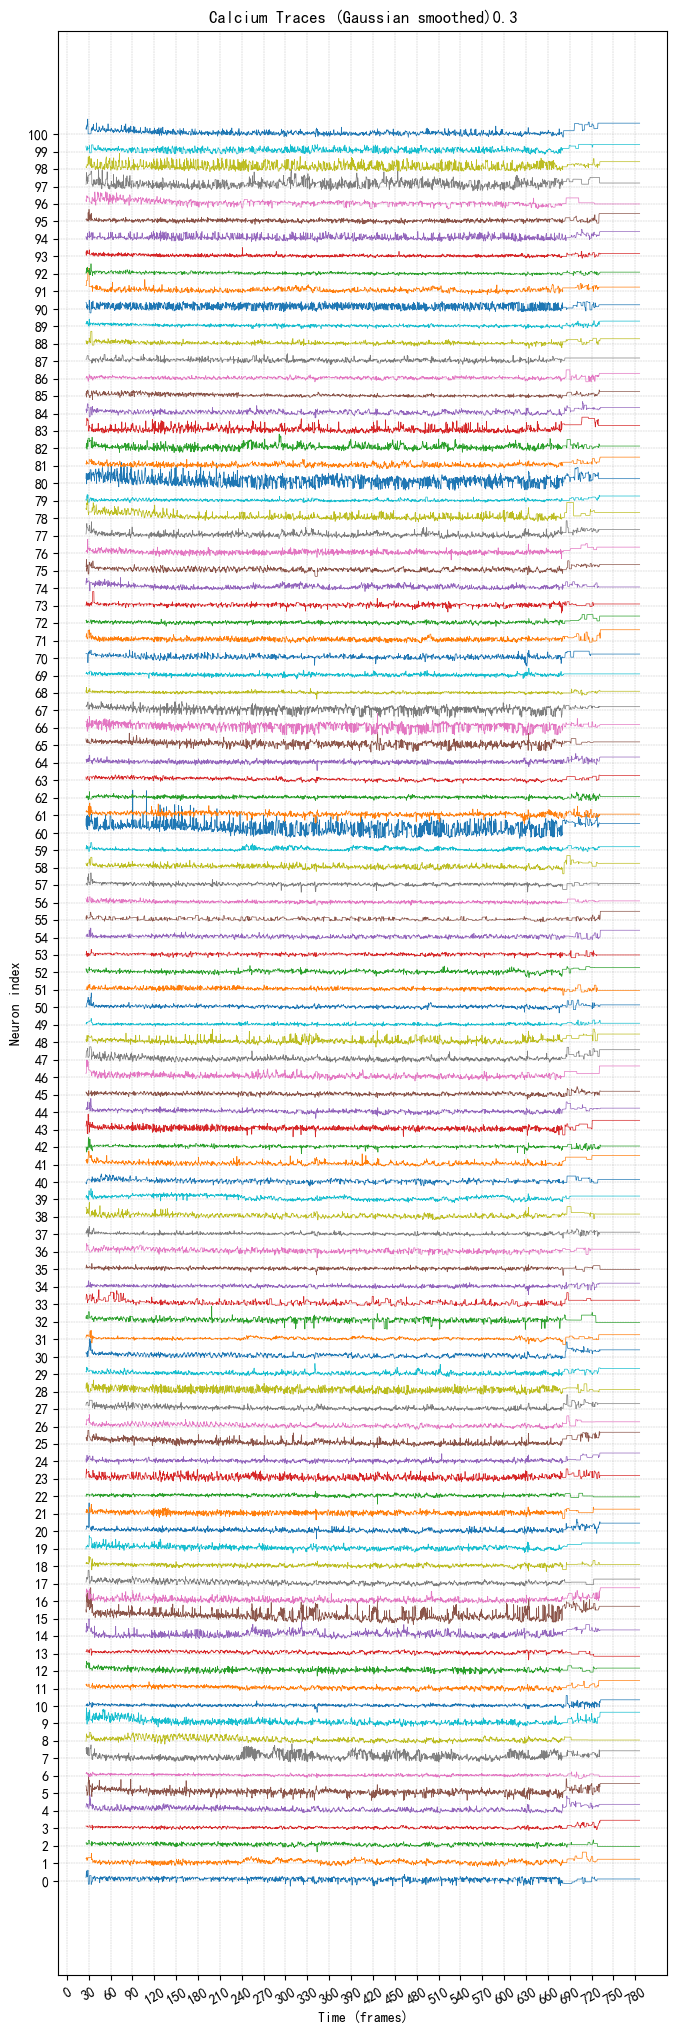

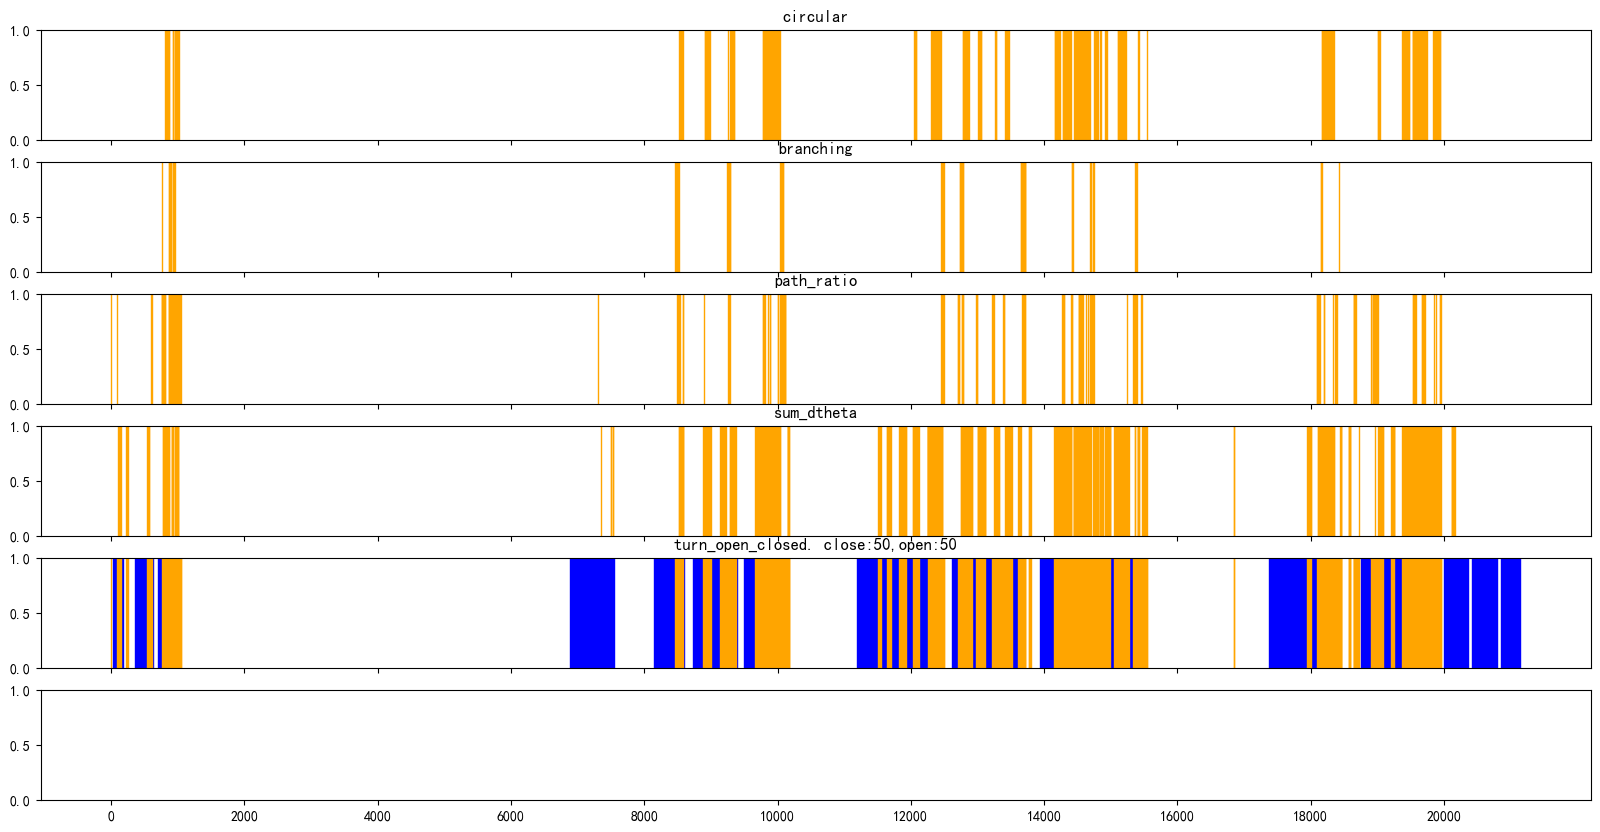

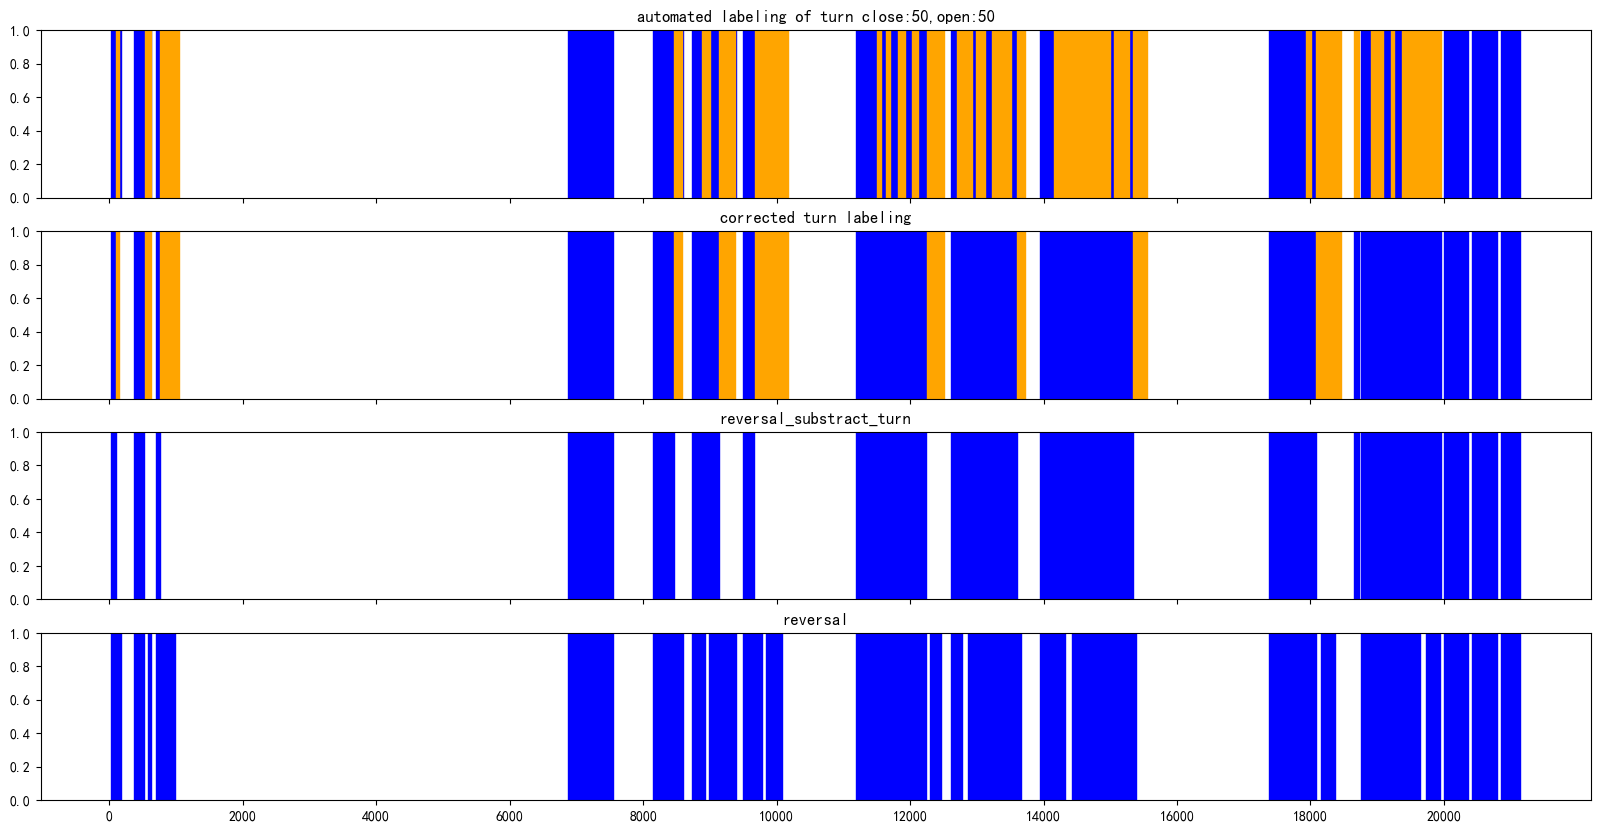

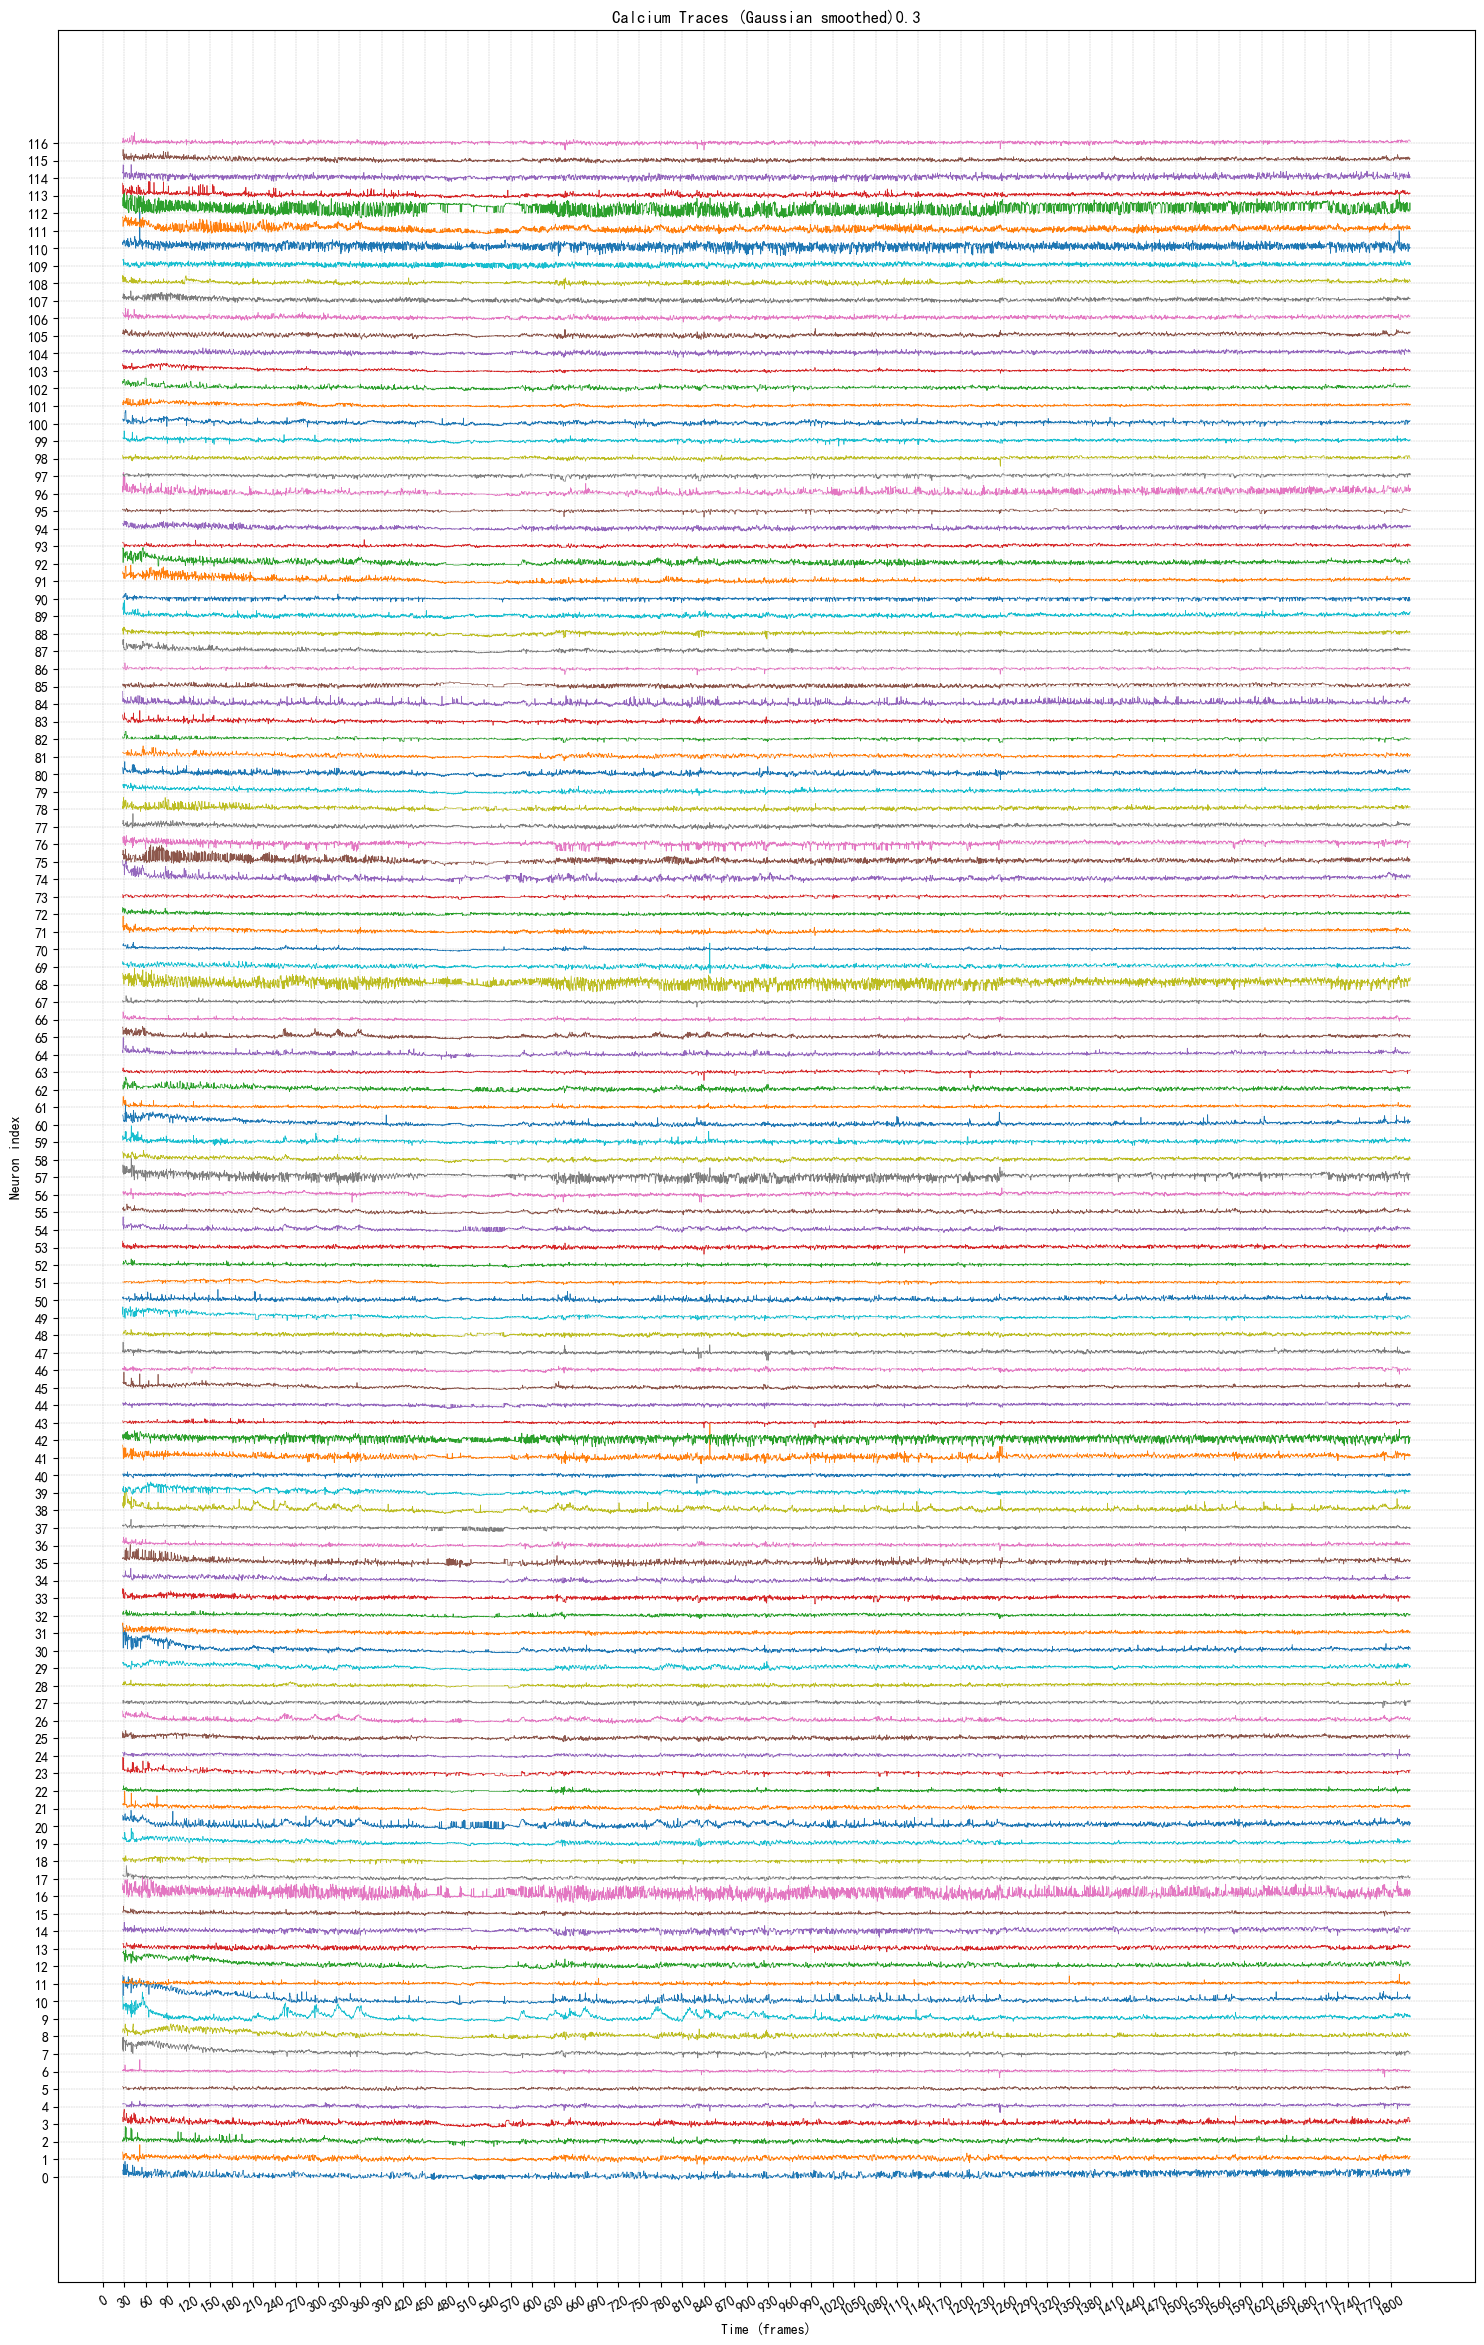

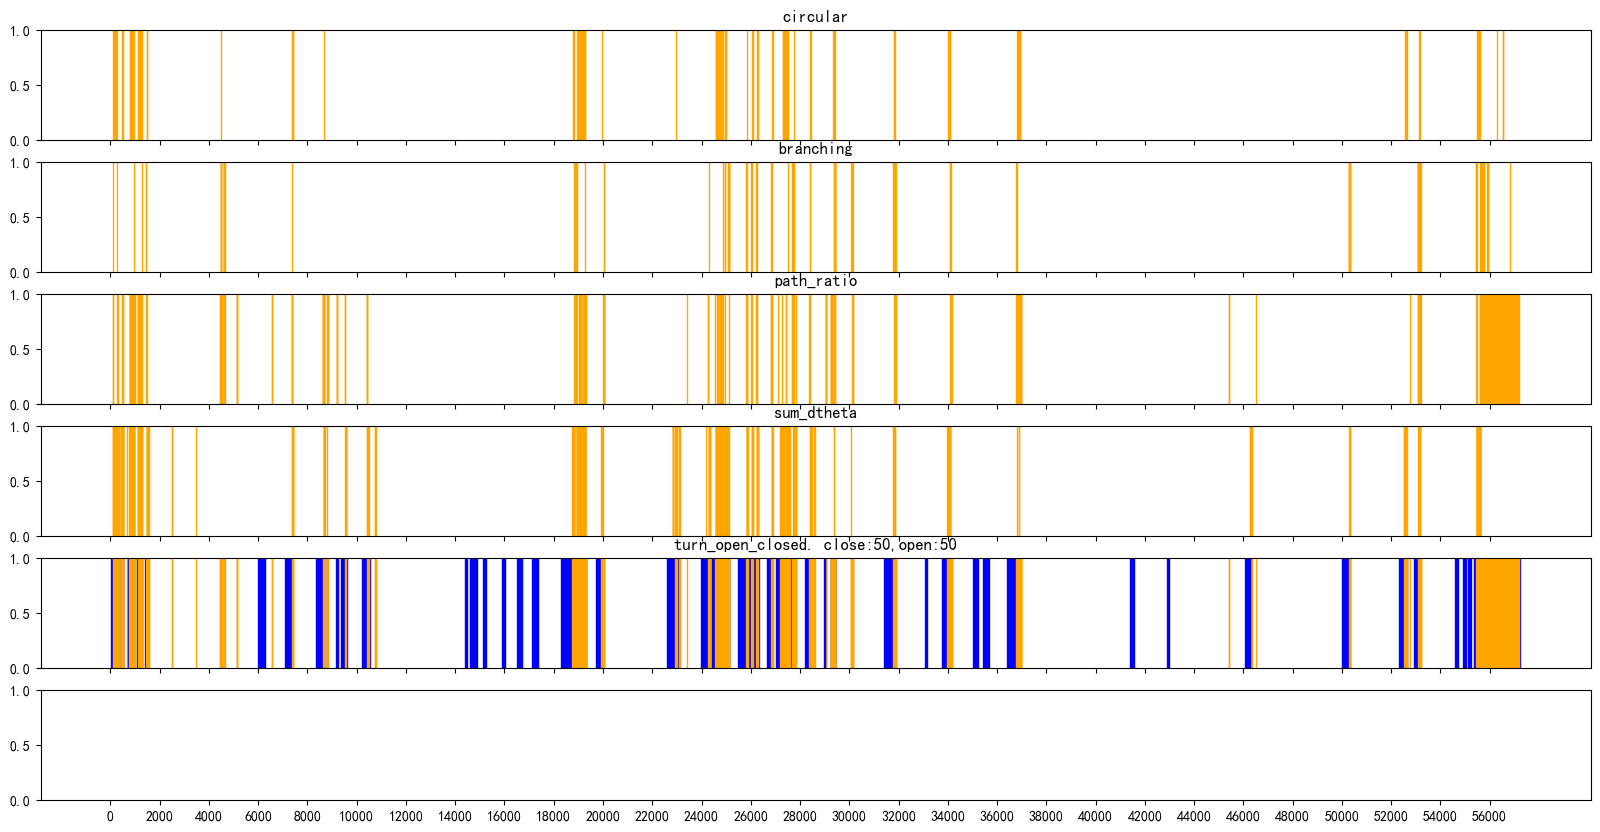

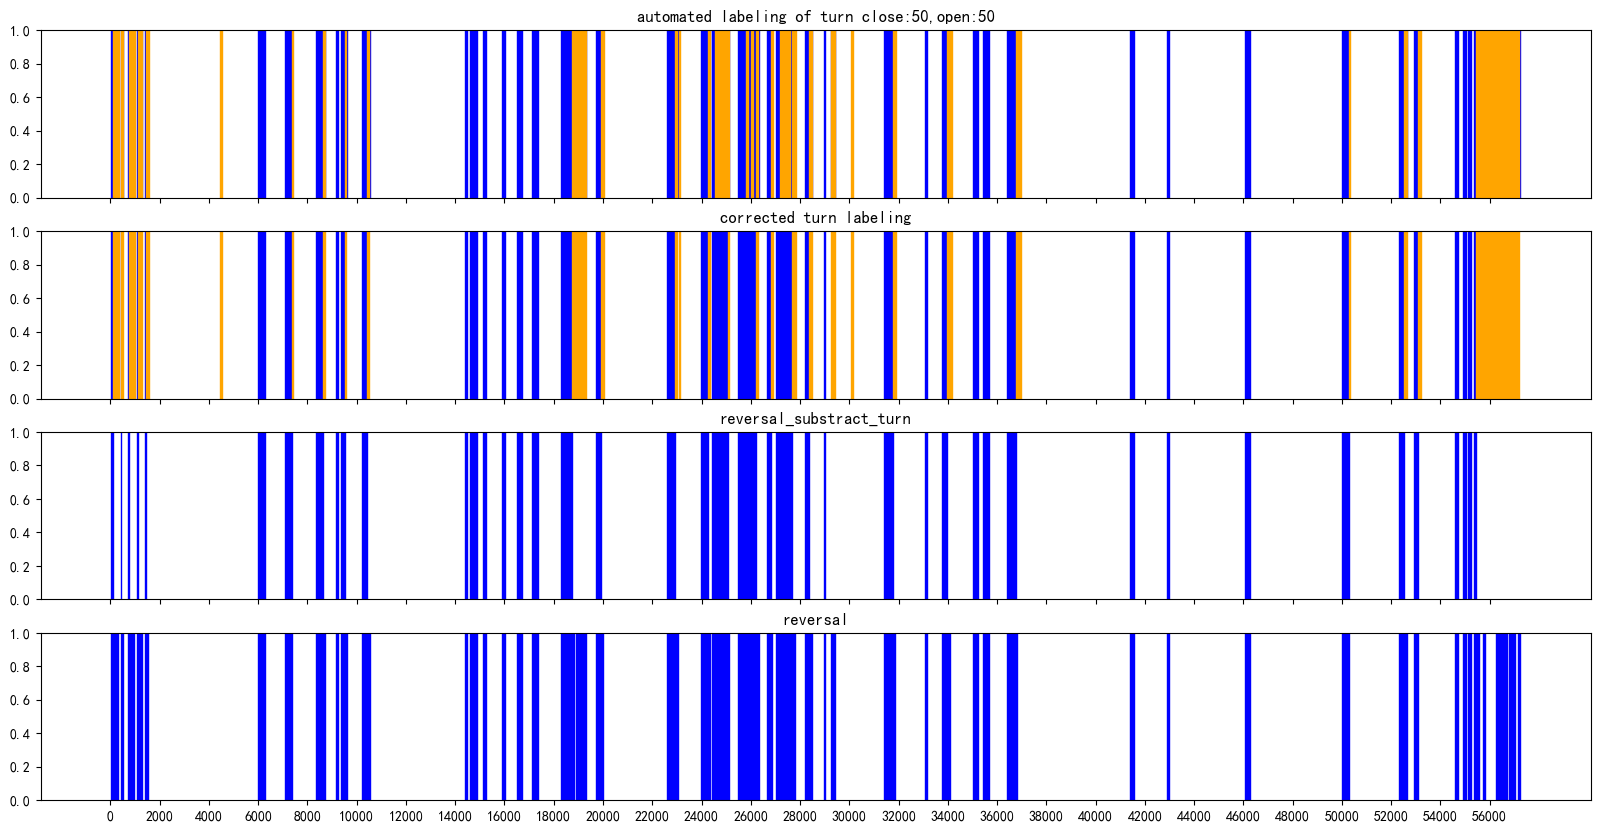

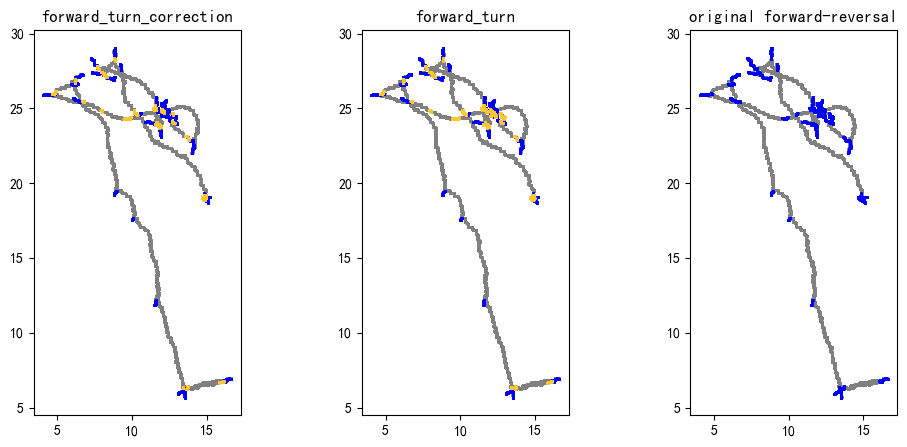

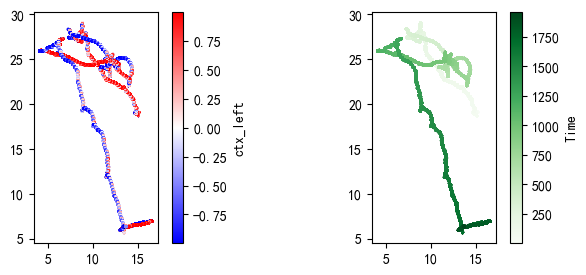

视频总帧数58615是否等于df行数: True
不存在骨架:frame 23420
不存在骨架:frame 24925
不存在骨架:frame 25135
不存在骨架:frame 25200
不存在骨架:frame 25225
不存在骨架:frame 25230
不存在骨架:frame 25960
不存在骨架:frame 26095
不存在骨架:frame 26115
不存在骨架:frame 26120
不存在骨架:frame 26250
不存在骨架:frame 26345
不存在骨架:frame 26350
不存在骨架:frame 26355
不存在骨架:frame 27180
不存在骨架:frame 27565
不存在骨架:frame 27735
不存在骨架:frame 27780
不存在骨架:frame 27805
不存在骨架:frame 27825
不存在骨架:frame 28070
不存在骨架:frame 28075
不存在骨架:frame 28235
不存在骨架:frame 28740
不存在骨架:frame 28765
不存在骨架:frame 28770
不存在骨架:frame 28775
不存在骨架:frame 28990
不存在骨架:frame 29420
不存在骨架:frame 29640
不存在骨架:frame 29660
不存在骨架:frame 29735
不存在骨架:frame 29750
不存在骨架:frame 29805
不存在骨架:frame 29830
不存在骨架:frame 29845
不存在骨架:frame 29850
不存在骨架:frame 30420
不存在骨架:frame 30425
不存在骨架:frame 30440
不存在骨架:frame 30445
不存在骨架:frame 30450
不存在骨架:frame 30460
不存在骨架:frame 30470
不存在骨架:frame 30475
不存在骨架:frame 30485
不存在骨架:frame 30490
不存在骨架:frame 30495
不存在骨架:frame 30500
不存在骨架:frame 30505
不存在骨架:frame 30510
不存在骨架:frame 30515
不存在骨架:frame 30520
不存在骨架:frame 30525
不存在

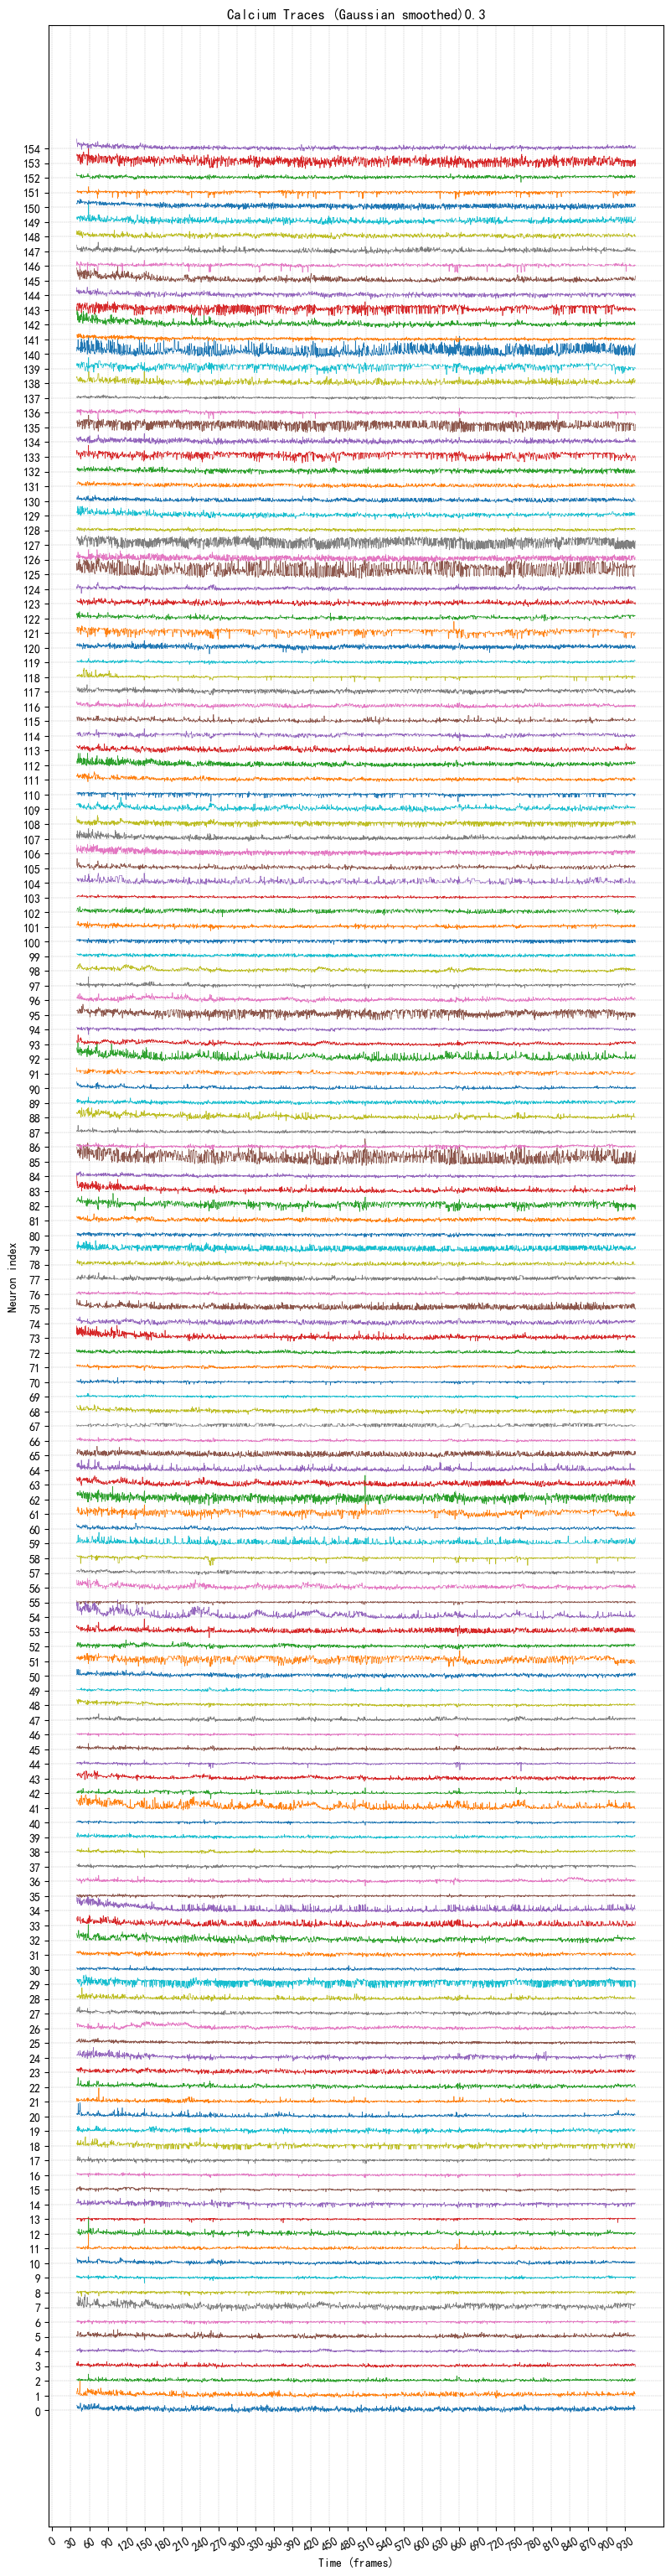

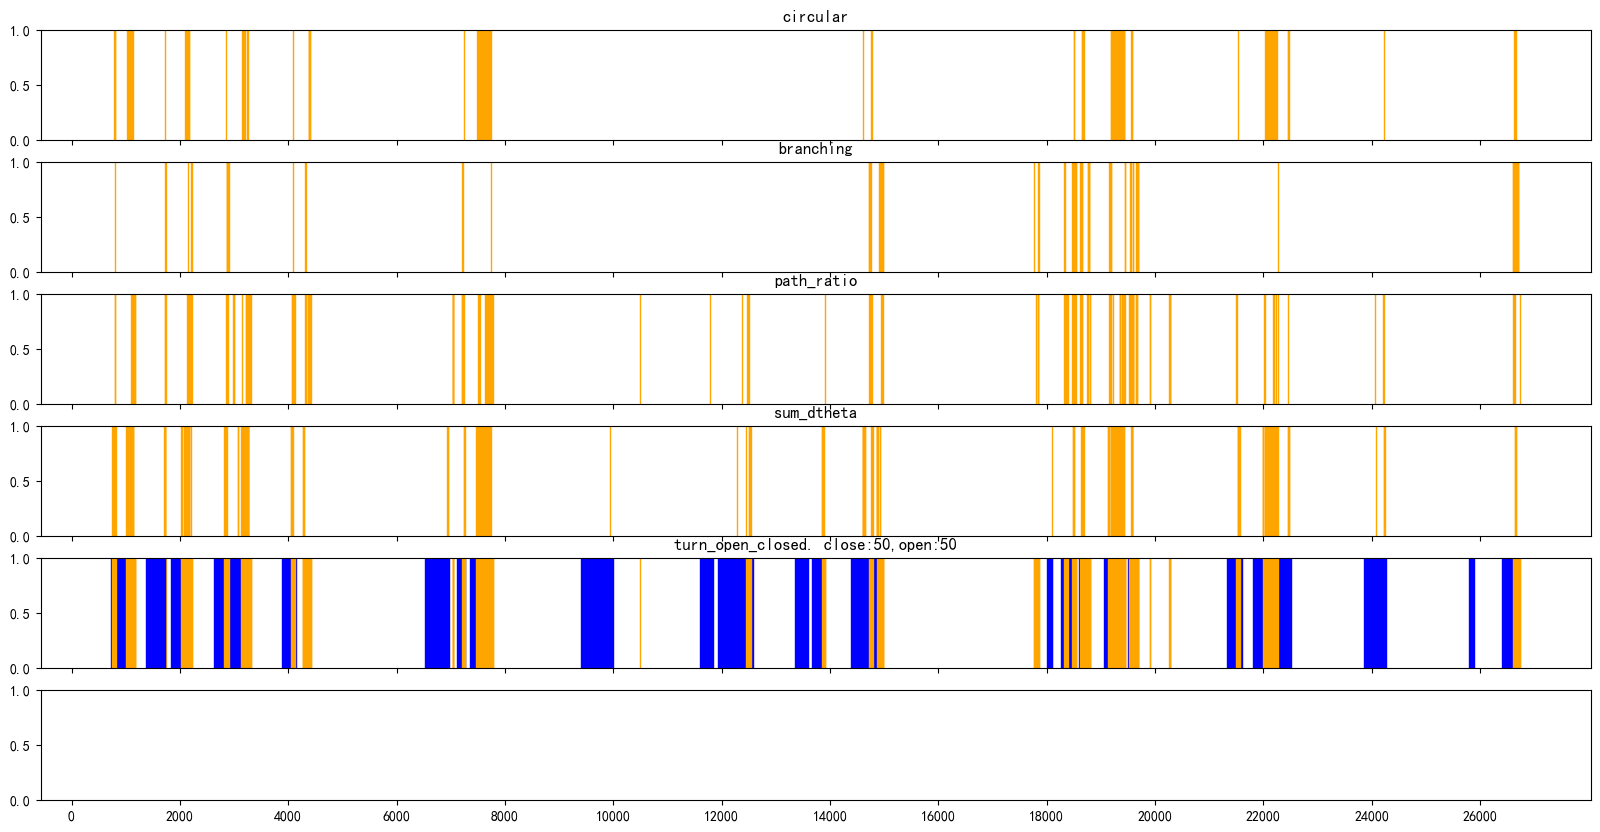

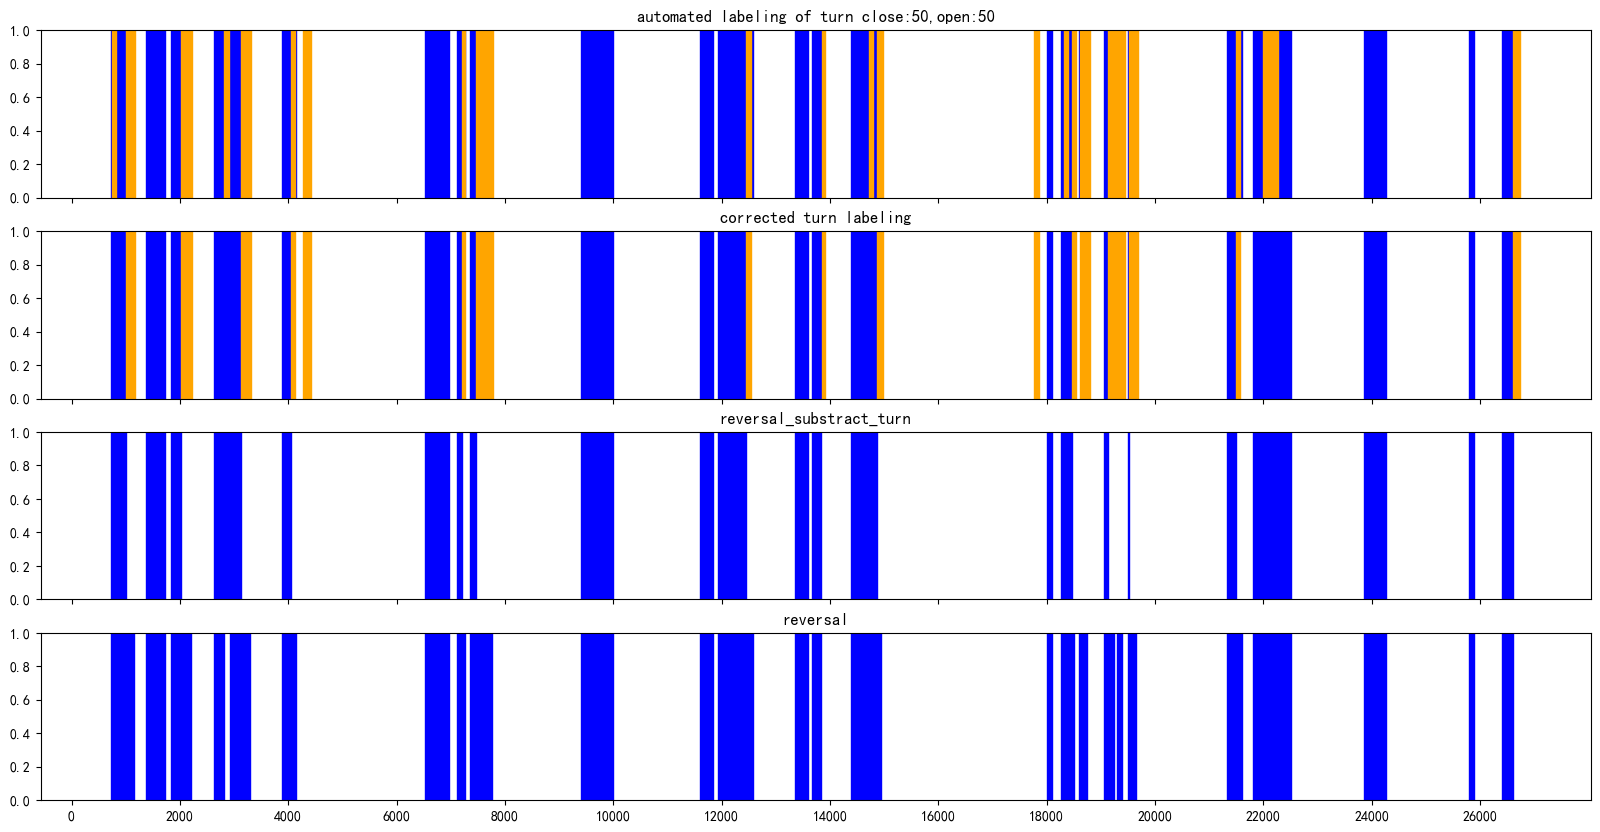

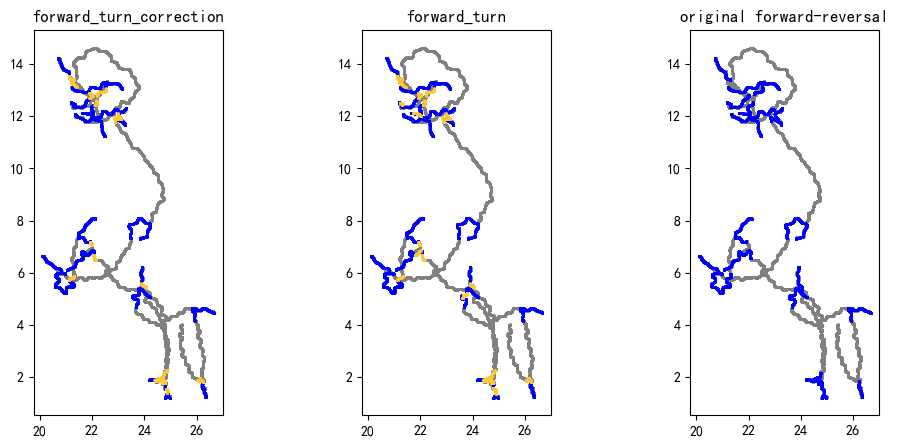

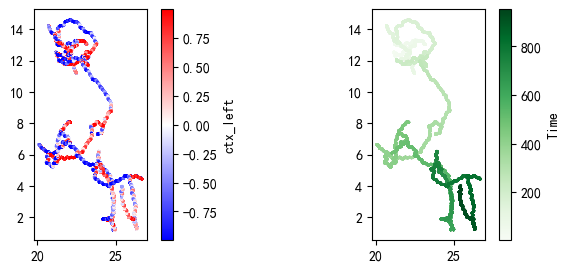

视频总帧数28556是否等于df行数: True
不存在骨架:frame 20005
不存在骨架:frame 20010
不存在骨架:frame 20015
不存在骨架:frame 20025
不存在骨架:frame 27050
不存在骨架:frame 27055
不存在骨架:frame 27060
不存在骨架:frame 27065
不存在骨架:frame 27070
不存在骨架:frame 27075
不存在骨架:frame 27080
不存在骨架:frame 27085
不存在骨架:frame 27090
不存在骨架:frame 27095
不存在骨架:frame 27100
不存在骨架:frame 27105
不存在骨架:frame 27115
不存在骨架:frame 27125
不存在骨架:frame 27130
不存在骨架:frame 27155
不存在骨架:frame 27160
不存在骨架:frame 27165
不存在骨架:frame 27170
不存在骨架:frame 27175
不存在骨架:frame 27180
不存在骨架:frame 27185
不存在骨架:frame 27190
不存在骨架:frame 27195
不存在骨架:frame 27200
不存在骨架:frame 27205
不存在骨架:frame 27210
不存在骨架:frame 27240
不存在骨架:frame 27250
不存在骨架:frame 27255
不存在骨架:frame 27260
不存在骨架:frame 27265
不存在骨架:frame 27270
不存在骨架:frame 27275
读取激光照射时间数据并转为s_data
时间间隔t_l 0.2999062603511096
写出与神经数据时间戳对应的运动/中线参数文件到:20250422_3g-lg9624-3h-24.5d_004_MotionMidlineMatchVol.pkl
========Y:\\SZX\\2025_wbi_analysis\\good_WBI\\REDO\20250422_3g-lg9624-3h-24.5d_004处理完成>.<===============


In [66]:
for i, p_f in enumerate(file_paths):
    basename = os.path.basename(p_f)
    date_str = basename.split('_')[0]
    new_data_date = datetime.strptime("20250201", "%Y%m%d") 
    date_end = datetime.strptime("20250804", "%Y%m%d")
    # 将日期字符串转换为datetime对象
    date = datetime.strptime(date_str, "%Y%m%d")
    # distinguish new data
    
    if date > new_data_date:
        new_data = True
        label_corner = True
    else:
        new_data = False
        label_corner = False
    print(basename, new_data, label_corner)
    if date < date_end:
        try:
            single_wbi_processing(p_f, label_corner, new_data, half_width = 20,x_shift  = 0)
        except:
            continue


### 异常数据mask并打印钙信号检查
根据可能的追踪异常情况，将4中得到的荧光对时文件打mask，提示异常帧

In [ ]:
p_f = r'Y:\\SZX\\2025_wbi_analysis\\good_WBI\\done\\20250116_4.5g-ov_05'

In [ ]:
# 求t_frame
files = [f for f in os.listdir(p_f)]
folder_name = os.path.basename(os.path.normpath(p_f))
for f in files:
    if ('laser-data' in f)or ("s-data" in f):
        # 读取激光激活数据
        print('读取激光照射时间数据并转为s_data')
        try:
            s_data = pd.read_csv(p_f + '\laser-data.txt', header=None)  #读取激光激活数据
        except FileNotFoundError:
            s_data = pd.read_csv(p_f + '\s-data.txt', header=None)
        # 注意：这里s_data已经转换成秒
        s_data.loc[:,0] = s_data.loc[:,0]/1000
    elif 'calcium_intensity.npy' in f:
                # 钙信号数据(* 如果有)
                print(f'读取钙信号数据：{p_f+f}')
                Cal_data_path = os.path.join(p_f, f)
                calcium_intensity= np.load(Cal_data_path)

# 步骤五：根据激光开始和结束时间截取荧光拍摄部分的运动数据/时间戳
t_frame, t_start, t_stop = get_laser_on_and_off(s_data)

In [ ]:
# 读入df_mot_midline_cut
f_mot_mid_cut = [f for f in os.listdir(p_f) if '_mot_midline_cut' in f][0]
print(f_mot_mid_cut)
df_mot_midline_cut = pd.read_csv(os.path.join(p_f,f_mot_mid_cut))

In [ ]:
# 如果没有mask
df_vol_time = pd.DataFrame(t_frame, columns=['Vol_Time'])   # 激光照射时间戳要转换单位为s
df_vol_time.to_csv(os.path.join(p_f, folder_name+'_VotTime.csv'), index = False)
# 有中线, 如果需要mask，write = False
df_mot_mid_vol = get_df_mot_matched_vol_t(df_mot_midline_cut,p_f, df_vol_time.copy(),
                                           ext_name = '_MotionMidlineMatchVol.csv', write=True)

In [ ]:
# 如果需要mask
df_vol_time = pd.DataFrame(t_frame, columns=['Vol_Time'])   # 激光照射时间戳要转换单位为s
df_vol_time.loc[:,'mask'] = 0 
df_vol_time.loc[df_vol_time['Vol_Time']<= 972,'mask'] = 1
df_vol_time.to_csv(os.path.join(p_f, folder_name+'_VotTime.csv'), index = False)

# 有中线的vol_time对齐文件
df_mot_mid_vol.loc[:,'mask'] = 0 
df_mot_mid_vol.loc[df_mot_mid_vol['Vol_Time']<= 972,'mask'] = 1
df_mot_mid_vol.to_csv(os.path.join(p_f, folder_name+'_MotionMidlineMatchVol.csv'), index = False)

In [ ]:
files = [f for f in os.listdir(p_f)]
for f in files:
    if ('laser-data' in f)or ("s-data" in f):
        # 读取激光激活数据
        print('读取激光照射时间数据并转为s_data')
        try:
            s_data = pd.read_csv(p_f + '\laser-data.txt', header=None)  #读取激光激活数据
        except FileNotFoundError:
            s_data = pd.read_csv(p_f + '\s-data.txt', header=None)
        # 注意：这里s_data已经转换成秒
        s_data.loc[:,0] = s_data.loc[:,0]/1000
    

In [ ]:
df_mot_mid_vol = pd.read_csv(os.path.join(p_f, folder_name+"_MotionMidlineMatchVol.csv"))
# 可视化钙信号检查
df_vol_mask = pd.read_csv(os.path.join(p_f, folder_name+"_VotTime.csv"))
# 有mask会自动标记
visualize_traces(p_f, calcium_intensity,df_vol_mask, smooth=True, sigma=0.3,delta_y=1.2 )

### 单文件处理函数（旧）

In [ ]:
p_f = r'Y:\SZX\\2025_wbi_analysis\\good_WBI\\new_midline_done\\20250221_0g-ov-27.5d_6'
def single_wbi_data_analysis(p_f, label_corner = True, new_data = True, half_width = 20, x_shift  = 0,
                              hlf_spd_inv = 0.5, hlf_agl_spd_inv = 0.2, hlf_agl_inv = 1,
                                Pos_CTX_vec = [-1,0]):
    
    # 检查文件
    is_contained, missing_files = is_contained_or_not(p_f, label_corner=label_corner)
    if is_contained:
        pass
    else:
        print(f'missing files{missing_files}')
        return None

    # 数据读取
    basename = os.path.basename(os.path.normpath(p_f))
    files = [f for f in os.listdir(p_f)]
    print(f'\n\n=======开始处理{basename}中文件，\n包含:{files}')
    for f in files:
        if 'stage_data' in f:
            # 使用载物台位置信息计算速度角速度
            print('读取载物台位置信息文件')
            column_names = ['Time','p_X','p_Y', 'X', 'Y']
            df_stage = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None,
                                    names=column_names)
            columns_to_clean = ['Time', 'p_X', 'p_Y', 'X', 'Y']
            for col in columns_to_clean:
                df_stage[col] = df_stage[col].astype(str).str.replace(',', '', regex=False).astype(float)

            df_motion = df_stage[['Time','X','Y']]/1000  # 转换单位为s和mm
            # 转换坐标，统一x轴坐标起点为0，终点为4.5
            # 保证p_f中有四个顶点文件
            if label_corner:
                df_label, df_motion = Realign_coordinate(p_f, df_motion)
            else:
                df_motion = Realign_coordinate_by_edge(p_f, df_motion)
        elif 'c1.txt' in f:
            # 读取视频帧文件
            print('读取视频帧时间戳文件并转为f_data')
            f_data = np.loadtxt(p_f + '\c1.txt', delimiter=',') # 读取相机时间戳
            if new_data: 
                # 202502之后的数据是新数据，视频帧率为30-40Hz
                t_c = f_data[f_data[:,3] == 1, 1]/1000
            else:
                # 旧数据视频帧率150Hz 每隔5帧取一帧（适用于老数据）
                indices = np.concatenate(([0], np.arange(5, len(f_data), 5)))
                t_c = f_data[indices, 1].astype(int)/1000
        elif ('laser-data' in f)or ("s-data" in f): 
            # 读取激光激活数据
            print('读取激光照射时间数据并转为s_data')
            try:
                s_data = pd.read_csv(p_f + '\laser-data.txt', header=None)  #读取激光激活数据
            except FileNotFoundError:
                s_data = pd.read_csv(p_f + '\s-data.txt', header=None)
            # 注意：这里s_data已经转换成秒
            s_data.loc[:,0] = s_data.loc[:,0]/1000
        elif 'output-0516' in f:
            # 中线npz数据(* 如果有)
            print(f'读取中线文件：{f}')
            midline_path = os.path.join(p_f,f)
            npz_data = np.load(midline_path, allow_pickle=True)
            data = npz_data['arr_0'].item()
            # paths= {key: value['all_paths'] for key, value in data.items()}
            data_keys = list(data.keys())   # 存储的符合条件的帧数
            midline_extract = True   # 是否包含抽取中线后的文件
        elif 'iou_results' in f:
            print(f'读取中线处理相关文件{f}')
            data_iou = np.load(os.path.join(p_f,'iou_results.npz'))
        
            
    # 步骤一：根据载物台运动位置信息抽取运动参数
    mean_frame_rate = np.median(1/np.diff(df_motion.Time.values))
    print(np.argmin(np.diff(df_motion.Time.values)))
    df_motion_als = Sliding_CTX_calation(df_motion, Pos_CTX_vec, hlf_spd_inv, hlf_agl_spd_inv, hlf_agl_inv,
                                        window_size=100, frame_rate=mean_frame_rate,X_shift=x_shift)


    # 步骤二： 提取视频帧（根据中线处理结果只保留可用帧）对应的运动参数，输出对齐视频可用帧时间后的运动参数文件
    df_motion_pt_sorted = df_motion_als.sort_values('Time')  # 确保 df_motion_pt 也是按时间升序
    df_t = pd.DataFrame({'Time': t_c})
    df_t = df_t.sort_values('Time')  # merge_asof 要求升序
    df_motion_pt_sorted = df_motion_pt_sorted.rename(columns={'Time': 'Stage_time'})
    # 使用 merge_asof 匹配最近的时间点
    df_matched = pd.merge_asof(
        df_t,
        df_motion_pt_sorted,
        left_on='Time',
        right_on='Stage_time',
        direction='nearest'  # 可选：'backward', 'forward', or 'nearest'
    )

    # 步骤三：加入condition
    folder_name = os.path.basename(os.path.normpath(p_f))
    df_matched = add_condition_info(folder_name, df_matched)
    # 重置中线位置
    df_matched['Disp_to_mid'] = df_matched['X']-half_width
    # 保存合并运动参数和视频帧对应时间戳的df数据
    df_matched.to_csv(os.path.join(p_f,basename+ '_mot_vid.csv'), index=False)
    '''文件长度与视频帧数相同'''

    # 步骤四:合并中线数据
    if midline_extract:

        # 整理choose帧
        choose_frame = get_choose_frame(data, data_keys, data_iou)
        df_choose = pd.DataFrame(choose_frame, columns=['key'])
        df_choose.loc[:,'choose_frame'] = int(1)
        df_choose = df_choose.set_index('key')

        rows = []
        for key in data_keys:
            item = data[key]
            row = {
                'key': key,   # 对应视频帧
                'angle_m': item['angle_m'],  # 头部朝向与运动方向夹角绝对值
                'angle_md': item['angle_md'],  # 头部朝向与运动方向夹角
                'all_paths':item['all_paths'],  # 完整的骨架信息
                'closest_idx':item['closest path'], # 最近的骨架id
            }
            rows.append(row)
        # 构建 DataFrame
        df_summary = pd.DataFrame(rows).set_index('key')
        # 保留所有的处理后的帧信息
        df_merged = df_matched.join(df_summary, how='left')

        # 保存筛选帧信息：哪些中线的置信度高于阈值
        df_merged = df_merged.join(df_choose, how='left')   # 根据index合并，df_choose里没有的填none

        # 中线处理，计算turn
        df_turn_curv = get_omega_turn_curvature(p_f, 
                                                midline_path, path_ratio_uplim = 1.5, path_uplim=200, dtheta_lim=220,
                                cl_turn_size = 50, op_turn_size = 50, visualize_turn=True,
                                seg_pixel_step = 13, agl_window = 300, frame_rate=38)
        df_merged_2 = df_merged.join(df_turn_curv, how='left')

        df_merged_2.to_csv(os.path.join(p_f,basename+ '_mot_vid_mid.csv'), index=False)
        '''文件仍然与视频长度相同，包含所有中线处理信息以及筛选帧信息'''

    # 步骤五：根据激光开始和结束时间截取荧光拍摄部分的运动数据/时间戳
    t_frame, t_start, t_stop = get_laser_on_and_off(s_data)
    track_start_index = np.searchsorted(df_matched.Time.values, t_start) - 1   # 截取激光照射段的载物台数据时间戳
    track_end_index = np.searchsorted(df_matched.Time.values, t_stop)
    df_matched_cut = df_matched.loc[track_start_index:track_end_index, :]
    df_vol_time = pd.DataFrame(t_frame, columns=['Vol_Time'])   # 激光照射时间戳要转换单位为s
    stage_file = os.path.join(p_f, f's{0+1}.txt')
    vol_file = os.path.join(p_f, f't{0+1}.txt')
    np.savetxt(stage_file, df_matched_cut[['Time','X_org','Y_org']], fmt='%.4f')  # 存储载物台数据(时间戳是视频帧的)
    np.savetxt(vol_file, t_frame, fmt='%.4f')  # 存储荧光每一个volume的数据
    df_matched_cut.to_csv(os.path.join(p_f, basename+'_mot_vid_cut.csv'), index = False)
    if midline_extract:
        df_mot_midline_cut = df_merged_2.loc[track_start_index:track_end_index, :]
        df_mot_midline_cut.to_csv(os.path.join(p_f, basename+'_mot_midline_cut.csv'), index = False)

    # 步骤六：根据荧光数据时间戳提取对应的运动参数，便于后续合并荧光数据
    # 如果有中线数据，就用带中线数据的对齐。否则只用运动参数对齐
    if midline_extract:
        df_mat_cut = df_mot_midline_cut.copy()
        print('有中线数据, 与Volume对齐的运动和中线数据')
    else:
        df_mat_cut = df_matched_cut.copy()
        print('没有中线数据, 输出与Volume时间对齐的运动参数')

    df_vol_time = get_nearest_value(df_mat_cut, df_vol_time, col_1 = 'Time', col_2 = 'Vol_Time', ind_col = 'Nearest_Index', col1_copy = 'Nearest_Time')
    # 将df_motionz中的运动参数(有中线加上中线)按照索引对应到视频帧文件的时间戳上
    columns_to_add = df_mat_cut.columns
    for col in columns_to_add:
        df_vol_time[col] = df_mat_cut.iloc[df_vol_time['Nearest_Index'].values][col].values
    if midline_extract:
        fn_motion_output = folder_name+'_MotionMidlineMatchVol.csv'
    else:
        fn_motion_output = folder_name+'_MotionMatchVol.csv'
    df_vol_time.to_csv(os.path.join(p_f, fn_motion_output), index = False)
    print(f'写出与神经数据时间戳(不包含钙数据)对应的运动参数文件到:{folder_name}/{fn_motion_output}')

In [ ]:
# 函数调用
file_path_all = r'Y:\\SZX\\2025_wbi_analysis\\good_WBI\\no_binary\\new'
key_word = ''
nokey_word = '*'
file_paths = [os.path.join(file_path_all,f_p) for f_p in os.listdir(file_path_all) if ('trash' not in f_p)&
              ('done' not in f_p)&
             os.path.isdir(os.path.join(file_path_all,f_p))&
             (key_word in f_p)&(nokey_word not in f_p)]

#### 单文件处理，旧代码

In [ ]:
#### 单文件处理，旧代码
p_f = r'Y:\SZX\\2025_wbi_analysis\\good_WBI\\new_midline_done\\20250221_0g-ov-27.5d_6'
label_corner = True
new_data = True   # 202502之后的数据是新数据，视频帧率为30-40Hz
half_width = 20   # 脂片宽度一半
x_shift  = 0 
hlf_spd_inv = 0.5
hlf_agl_spd_inv = 0.2
hlf_agl_inv = 1
Pos_CTX_vec = [-1,0]
t_crit = 3.8
min_agl_spd = 75
df_motion = {}
df_vol_time = {}
calcium = True   # 默认有荧光信号的所有文件都包含钙信号

is_contained, missing_files = is_contained_or_not(p_f, label_corner=label_corner)
if is_contained:
    pass
else:
    print(f'missing files{missing_files}')


# 数据读取
basename = os.path.basename(os.path.normpath(p_f))
files = [f for f in os.listdir(p_f)]
print(f'\n\n=======开始处理{basename}中文件，\n包含:{files}')
for f in files:
    if 'stage_data' in f:
        # 使用载物台位置信息计算速度角速度
        print('读取载物台位置信息文件')
        column_names = ['Time','p_X','p_Y', 'X', 'Y']
        df_stage = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None,
                                names=column_names)
        columns_to_clean = ['Time', 'p_X', 'p_Y', 'X', 'Y']
        for col in columns_to_clean:
            df_stage[col] = df_stage[col].astype(str).str.replace(',', '', regex=False).astype(float)

        df_motion = df_stage[['Time','X','Y']]/1000  # 转换单位为s和mm
        # 转换坐标，统一x轴坐标起点为0，终点为4.5
        # 保证p_f中有四个顶点文件
        if label_corner:
            df_label, df_motion = Realign_coordinate(p_f, df_motion)
        else:
            df_motion = Realign_coordinate_by_edge(p_f, df_motion)

    elif 'c1.txt' in f:
        # 读取视频帧文件
        print('读取视频帧时间戳文件并转为f_data')
        f_data = np.loadtxt(p_f + '\c1.txt', delimiter=',') # 读取相机时间戳
        if new_data: 
            # 202502之后的数据是新数据，视频帧率为30-40Hz
            t_c = f_data[f_data[:,3] == 1, 1]/1000
        else:
            # 旧数据视频帧率150Hz 每隔5帧取一帧（适用于老数据）
            indices = np.concatenate(([0], np.arange(5, len(f_data), 5)))
            t_c = f_data[indices, 1].astype(int)/1000
    elif ('laser-data' in f)or ("s-data" in f):
        # 读取激光激活数据
        print('读取激光照射时间数据并转为s_data')
        try:
            s_data = pd.read_csv(p_f + '\laser-data.txt', header=None)  #读取激光激活数据
        except FileNotFoundError:
            s_data = pd.read_csv(p_f + '\s-data.txt', header=None)
        # 注意：这里s_data已经转换成秒
        s_data.loc[:,0] = s_data.loc[:,0]/1000
    elif 'calcium_intensity.npy' in f:
        # 钙信号数据(* 如果有)
        print(f'读取钙信号数据：{f}')
        Cal_data_path = os.path.join(p_f, f)
        calcium_intensity= np.load(Cal_data_path)
        Calcium = True    # 包含钙信号数据
    elif 'output-0516' in f:
        # 中线npz数据(* 如果有)
        print(f'读取中线文件：{f}')
        midline_path = os.path.join(p_f,f)
        npz_data = np.load(midline_path, allow_pickle=True)
        data = npz_data['arr_0'].item()
        # paths= {key: value['all_paths'] for key, value in data.items()}
        data_keys = list(data.keys())   # 存储的符合条件的帧数
        midline_extract = True   # 是否包含抽取中线后的文件
    elif 'iou_results' in f:
        print(f'读取中线处理相关文件{f}')
        data_iou = np.load(os.path.join(p_f,'iou_results.npz'))
    
        
# 步骤一：根据载物台运动位置信息抽取运动参数
mean_frame_rate = np.median(1/np.diff(df_motion.Time.values))
print(np.argmin(np.diff(df_motion.Time.values)))
df_motion_als = Sliding_CTX_calation(df_motion, Pos_CTX_vec, hlf_spd_inv, hlf_agl_spd_inv, hlf_agl_inv,
                                    window_size=100, frame_rate=mean_frame_rate,X_shift=x_shift)


# 步骤二： 提取视频帧（根据中线处理结果只保留可用帧）对应的运动参数，输出对齐视频可用帧时间后的运动参数文件
df_motion_pt_sorted = df_motion_als.sort_values('Time')  # 确保 df_motion_pt 也是按时间升序
df_t = pd.DataFrame({'Time': t_c})
df_t = df_t.sort_values('Time')  # merge_asof 要求升序
df_motion_pt_sorted = df_motion_pt_sorted.rename(columns={'Time': 'Stage_time'})
# 使用 merge_asof 匹配最近的时间点
df_matched = pd.merge_asof(
    df_t,
    df_motion_pt_sorted,
    left_on='Time',
    right_on='Stage_time',
    direction='nearest'  # 可选：'backward', 'forward', or 'nearest'
)

# 步骤三：加入condition
folder_name = os.path.basename(os.path.normpath(p_f))
df_matched = add_condition_info(folder_name, df_matched)
# 重置中线位置
df_matched['Disp_to_mid'] = df_matched['X']-half_width
# 保存合并运动参数和视频帧对应时间戳的df数据
df_matched.to_csv(os.path.join(p_f,basename+ '_mot_vid.csv'), index=False)
'''文件长度与视频帧数相同'''

# 步骤四:合并中线数据
if midline_extract:

    # 整理choose帧
    choose_frame = get_choose_frame(data, data_keys, data_iou)
    df_choose = pd.DataFrame(choose_frame, columns=['key'])
    df_choose.loc[:,'choose_frame'] = int(1)
    df_choose = df_choose.set_index('key')

    rows = []
    for key in data_keys:
        item = data[key]
        row = {
            'key': key,   # 对应视频帧
            'angle_m': item['angle_m'],  # 头部朝向与运动方向夹角绝对值
            'angle_md': item['angle_md'],  # 头部朝向与运动方向夹角
            'all_paths':item['all_paths'],  # 完整的骨架信息
            'closest_idx':item['closest path'], # 最近的骨架id
        }
        rows.append(row)
    # 构建 DataFrame
    df_summary = pd.DataFrame(rows).set_index('key')
    # 保留所有的处理后的帧信息
    df_merged = df_matched.join(df_summary, how='left')

    # 保存筛选帧信息：哪些中线的置信度高于阈值
    df_merged = df_merged.join(df_choose, how='left')   # 根据index合并，df_choose里没有的填none

    # 中线处理，计算turn
    df_turn_curv = get_omega_turn_curvature(midline_path, path_ratio_uplim = 1.5, path_uplim=200, dtheta_lim=220,
                              cl_turn_size = 50, op_turn_size = 50, visualize_turn=True,
                              seg_pixel_step = 13, agl_window = 300, frame_rate=38)
    df_merged_2 = df_merged.join(df_turn_curv, how='left')

    df_merged_2.to_csv(os.path.join(p_f,basename+ '_mot_vid_mid.csv'), index=False)
    '''文件仍然与视频长度相同，包含所有中线处理信息以及筛选帧信息'''

# 步骤五：根据激光开始和结束时间截取荧光拍摄部分的运动数据/时间戳
t_frame, t_start, t_stop = get_laser_on_and_off(s_data)
track_start_index = np.searchsorted(df_matched.Time.values, t_start) - 1   # 截取激光照射段的载物台数据时间戳
track_end_index = np.searchsorted(df_matched.Time.values, t_stop)
df_matched_cut = df_matched.loc[track_start_index:track_end_index, :]
df_vol_time = pd.DataFrame(t_frame, columns=['Vol_Time'])   # 激光照射时间戳要转换单位为s
stage_file = os.path.join(p_f, f's{0+1}.txt')
vol_file = os.path.join(p_f, f't{0+1}.txt')
np.savetxt(stage_file, df_matched_cut[['Time','X_org','Y_org']], fmt='%.4f')  # 存储载物台数据(时间戳是视频帧的)
np.savetxt(vol_file, t_frame, fmt='%.4f')  # 存储荧光每一个volume的数据
df_matched_cut.to_csv(os.path.join(p_f, basename+'_mot_vid_cut.csv'), index = False)
if midline_extract:
    df_mot_midline_cut = df_merged_2.loc[track_start_index:track_end_index, :]
    df_mot_midline_cut.to_csv(os.path.join(p_f, basename+'_mot_midline_cut.csv'), index = False)

# 步骤六：根据荧光数据时间戳提取对应的运动参数，便于后续合并荧光数据
# 如果有中线数据，就用带中线数据的对齐。否则只用运动参数对齐
if midline_extract:
    df_mat_cut = df_mot_midline_cut.copy()
    print('有中线数据, 与Volume对齐的运动和中线数据')
else:
    df_mat_cut = df_matched_cut.copy()
    print('没有中线数据, 输出与Volume时间对齐的运动参数')

df_vol_time = get_nearest_value(df_mat_cut, df_vol_time, col_1 = 'Time', col_2 = 'Vol_Time', ind_col = 'Nearest_Index', col1_copy = 'Nearest_Time')
# 将df_motionz中的运动参数(有中线加上中线)按照索引对应到视频帧文件的时间戳上
columns_to_add = df_mat_cut.columns
for col in columns_to_add:
    df_vol_time[col] = df_mat_cut.iloc[df_vol_time['Nearest_Index'].values][col].values
if midline_extract:
    fn_motion_output = folder_name+'_MotionMidlineMatchVol.csv'
else:
    fn_motion_output = folder_name+'_MotionMatchVol.csv'
df_vol_time.to_csv(os.path.join(p_f, fn_motion_output), index = False)
print(f'写出与神经数据时间戳(不包含钙数据)对应的运动参数文件到:{folder_name}/{fn_motion_output}')